# Importación de Librerías
Importar todas las dependencias necesarias para el análisis estadístico, modelado matemático y visualización de datos genéticos.

In [30]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Librerías para análisis estadístico
from scipy import stats
from scipy.stats import poisson, expon, chi2_contingency
from scipy.optimize import minimize

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Librerías para modelado
from sklearn.preprocessing import LabelEncoder
from collections import Counter

print("Librerías importadas exitosamente")
print(f"Versión de pandas: {pd.__version__}")
print(f"Versión de numpy: {np.__version__}")

Librerías importadas exitosamente
Versión de pandas: 2.2.2
Versión de numpy: 1.26.4


# Carga y Exploración Inicial del Dataset
Carga el dataset TP53 UMD desde el archivo Excel y realiza una exploración preliminar para comprender la estructura y calidad de los datos.

In [31]:
# Carga del dataset
file_path = 'mutaciones_es.xlsx'
df_raw = pd.read_excel(file_path)

# Exploración inicial
print("="*80)
print("EXPLORACIÓN INICIAL DEL DATASET TP53 UMD")
print("="*80)
print(f"\nDimensiones del dataset: {df_raw.shape[0]:,} filas × {df_raw.shape[1]} columnas")
print(f"Memoria utilizada: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Información general
print("\n" + "-"*80)
print("ESTRUCTURA DE DATOS")
print("-"*80)
print(df_raw.info())

# Estadísticas descriptivas de columnas numéricas clave
print("\n" + "-"*80)
print("ESTADÍSTICAS DESCRIPTIVAS DE COLUMNAS RELEVANTES")
print("-"*80)
numeric_cols = ['Records_Number', 'Tumor_Stat', 'Leukemia_Stat', 
                'Solid_Stat', 'Somatic_Stat', 'Year']
print(df_raw[numeric_cols].describe())

# Visualización de valores faltantes
print("\n" + "-"*80)
print("ANÁLISIS DE VALORES FALTANTES")
print("-"*80)
missing_summary = pd.DataFrame({
    'Columna': df_raw.columns,
    'Valores_Faltantes': df_raw.isnull().sum(),
    'Porcentaje': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Valores_Faltantes'] > 0].sort_values(
    'Porcentaje', ascending=False
)
print(missing_summary.head(20))

EXPLORACIÓN INICIAL DEL DATASET TP53 UMD

Dimensiones del dataset: 80,406 filas × 133 columnas
Memoria utilizada: 539.45 MB

--------------------------------------------------------------------------------
ESTRUCTURA DE DATOS
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80406 entries, 0 to 80405
Columns: 133 entries, Database_ID to Pathogenicity
dtypes: float64(6), int64(7), object(120)
memory usage: 81.6+ MB
None

--------------------------------------------------------------------------------
ESTADÍSTICAS DESCRIPTIVAS DE COLUMNAS RELEVANTES
--------------------------------------------------------------------------------
       Records_Number    Tumor_Stat  Leukemia_Stat    Solid_Stat  \
count    80406.000000  80406.000000   80406.000000  80406.000000   
mean       617.785140      0.772338       0.701378      0.776156   
std        948.298658      1.184317       1.146366      1.194027   
min         

# Selección y Traducción de Columnas Relevantes

Seleccionamos únicamente las columnas necesarias para el modelado de Procesos de Poisson y traduce sus nombres al español según la documentación técnica.

In [32]:
# Definición de columnas relevantes según documentación TP53 UMD
columnas_seleccionadas = {
    # Identificación
    'ID_Base_Datos': 'ID_Mutación',
    'cDNA_variant': 'Variante_cDNA',
    'Codon': 'Codón',
    
    # Tipo de mutación
    'Type': 'Tipo_Evento',
    'Mutation_Type': 'Clase_Mutación',
    'Variant_Classification': 'Efecto_Traducción',
    'Mutational_event': 'Evento_Mutacional',
    
    # Frecuencias (variables clave para lambda)
    'Records_Number': 'Número_Ocurrencias',
    'Tumor_Stat': 'Frecuencia_Tumores',
    'Leukemia_Stat': 'Frecuencia_Leucemias',
    'Solid_Stat': 'Frecuencia_Sólidos',
    'Somatic_Stat': 'Frecuencia_Somática',
    'Germline_Stat': 'Frecuencia_Germinal',
    
    # Contexto clínico
    'Disease': 'Enfermedad',
    'Mutation_origin': 'Origen',
    'Sample_pathology': 'Patología_Muestra',
    
    # Hotspots mutacionales
    'CpG': 'Sitio_CpG',
    'Py_Py_Doublets': 'Dobletes_Pirimidina',
    'Domain': 'Dominio_Funcional',
    'Exon:intron_start': 'Región_Génica',
    
    # Temporal
    'Year': 'Año',
    
    # Complejidad
    'Complexity': 'Complejidad',
    'Tumor_Repetition': 'Repetición_Tumor',
    
    # Validación de calidad
    'PCA_Outliers': 'Publicación_Outlier',
    'PCA_Score': 'Score_Calidad',
    
    # Predictores funcionales
    'Comment_activity': 'Actividad_Residual',
    'Pathogenicity': 'Patogenicidad'
}

# Verificar columnas disponibles
columnas_disponibles = [col for col in columnas_seleccionadas.keys() if col in df_raw.columns]
columnas_faltantes = [col for col in columnas_seleccionadas.keys() if col not in df_raw.columns]

print("="*80)
print("SELECCIÓN DE COLUMNAS PARA MODELADO DE POISSON")
print("="*80)
print(f"\nColumnas encontradas: {len(columnas_disponibles)}/{len(columnas_seleccionadas)}")
print(f"Columnas faltantes: {len(columnas_faltantes)}")

if columnas_faltantes:
    print("\nColumnas no encontradas en el dataset:")
    for col in columnas_faltantes[:10]:
        print(f"  - {col}")

# Crear dataset reducido con columnas disponibles
df_selected = df_raw[columnas_disponibles].copy()
df_selected.rename(columns={k: columnas_seleccionadas[k] for k in columnas_disponibles}, 
                   inplace=True)

print(f"\n✓ Dataset reducido creado: {df_selected.shape[0]:,} filas × {df_selected.shape[1]} columnas")
print(f"✓ Reducción de tamaño: {(1 - df_selected.shape[1]/df_raw.shape[1])*100:.1f}%")

df_selected.head()

SELECCIÓN DE COLUMNAS PARA MODELADO DE POISSON

Columnas encontradas: 24/27
Columnas faltantes: 3

Columnas no encontradas en el dataset:
  - ID_Base_Datos
  - PCA_Outliers
  - Comment_activity

✓ Dataset reducido creado: 80,406 filas × 24 columnas
✓ Reducción de tamaño: 82.0%


,Variante_cDNA,Codón,Tipo_Evento,Clase_Mutación,Efecto_Traducción,Evento_Mutacional,Número_Ocurrencias,Frecuencia_Tumores,Frecuencia_Leucemias,Frecuencia_Sólidos,...,Patología_Muestra,Sitio_CpG,Dobletes_Pirimidina,Dominio_Funcional,Región_Génica,Año,Complejidad,Repetición_Tumor,Score_Calidad,Patogenicidad
0,c.445_445delT,149,Fr,D,Frame_Shift_Del,Deletion,25,0.033,0.027,0.031,...,Cancer,No,No,DNA binding,5,2015,SM,1,"0,389",Likely Pathogenic
1,c.456_456dupG,152,Fr,I,Frame_Shift_Ins,Insertion,9,0.012,0.000,0.013,...,Cancer,No,No,DNA binding,5,2015,SM,1,0,Likely Pathogenic
2,c.782G>A,261,Ts,B,Missense_Mutation,G>A,8,0.011,0.000,0.011,...,Cancer,No,Yes_non_coding_strand,DNA binding,7,2017,SM,1,0,VUS
3,c.(?_-202)_(*1207_?),?,Fr,D,Gene_Deletion,Deletion,60,0.053,0.014,0.082,...,Cancer,NR,No,NaN,?,2014,SM,1,0,Pathogenic
4,c.817C>T,273,Ts,B,Missense_Mutation,C>T,2214,2.803,2.107,2.844,...,Cancer,Yes,No,HCD V - DNA binding,8,2015,SM,1,"0,812",Pathogenic


# Limpieza y Preprocesamiento de Datos
Realizamos la limpieza de datos, tratamiento de valores faltantes y transformación de variables para garantizar la calidad del análisis estadístico.

In [42]:
# Crear copia para preprocesamiento
df_clean = df_selected.copy()

# Eliminar filas con valores nulos
print("\n[7/6] Eliminando filas con valores nulos...")

filas_antes = len(df_clean)
df_clean = df_clean.replace(['NULL', 'null', '?', 'NaN', ''], np.nan)
df_clean = df_clean.dropna()
filas_despues = len(df_clean)

print(f"    ✓ Filas eliminadas: {filas_antes - filas_despues}")
print(f"    ✓ Filas restantes: {filas_despues}")

print("="*80)
print("LIMPIEZA Y PREPROCESAMIENTO DE DATOS")
print("="*80)

# 1. Limpieza de la variable clave: Número_Ocurrencias
print("\n[1/6] Procesando Número_Ocurrencias (variable λ)...")
df_clean['Número_Ocurrencias'] = pd.to_numeric(df_clean['Número_Ocurrencias'], errors='coerce')
df_clean['Número_Ocurrencias'].fillna(1, inplace=True)
df_clean['Número_Ocurrencias'] = df_clean['Número_Ocurrencias'].astype(int)
print(f"    ✓ Rango: {df_clean['Número_Ocurrencias'].min()} - {df_clean['Número_Ocurrencias'].max()}")
print(f"    ✓ Media: {df_clean['Número_Ocurrencias'].mean():.2f}")
print(f"    ✓ Mediana: {df_clean['Número_Ocurrencias'].median():.2f}")

# 2. Limpieza de frecuencias estadísticas
print("\n[2/6] Procesando frecuencias estadísticas...")
freq_cols = ['Frecuencia_Tumores', 'Frecuencia_Leucemias', 'Frecuencia_Sólidos', 
             'Frecuencia_Somática', 'Frecuencia_Germinal']
for col in freq_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        df_clean[col].fillna(0, inplace=True)
print(f"    ✓ {len([c for c in freq_cols if c in df_clean.columns])} columnas procesadas")

# 3. Procesamiento de variables temporales
print("\n[3/6] Procesando variable temporal (Año)...")
if 'Año' in df_clean.columns:
    df_clean['Año'] = pd.to_numeric(df_clean['Año'], errors='coerce')
    año_valido = df_clean['Año'].notna()
    print(f"    ✓ Años válidos: {año_valido.sum():,} ({año_valido.sum()/len(df_clean)*100:.1f}%)")
    print(f"    ✓ Rango temporal: {int(df_clean['Año'].min())} - {int(df_clean['Año'].max())}")

# 4. Procesamiento de variables categóricas
print("\n[4/6] Procesando variables categóricas...")
categorical_cols = ['Tipo_Evento', 'Clase_Mutación', 'Efecto_Traducción', 
                    'Origen', 'Enfermedad', 'Sitio_CpG']
for col in categorical_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).replace('nan', 'Unknown')
        n_categories = df_clean[col].nunique()
        print(f"    ✓ {col}: {n_categories} categorías únicas")

# 5. Procesamiento de calidad de datos
print("\n[5/6] Procesando indicadores de calidad...")
if 'Score_Calidad' in df_clean.columns:
    df_clean['Score_Calidad'] = pd.to_numeric(df_clean['Score_Calidad'], errors='coerce')
    df_clean['Datos_Confiables'] = df_clean['Score_Calidad'] < 2.0
    n_confiables = df_clean['Datos_Confiables'].sum()
    print(f"    ✓ Registros confiables (Score < 2): {n_confiables:,} ({n_confiables/len(df_clean)*100:.1f}%)")

# 6. Identificación de hotspots (sitios CpG)
print("\n[6/6] Identificando hotspots mutacionales...")
if 'Sitio_CpG' in df_clean.columns:
    df_clean['Es_Hotspot'] = df_clean['Sitio_CpG'].str.lower() == 'yes'
    n_hotspots = df_clean['Es_Hotspot'].sum()
    print(f"    ✓ Mutaciones en sitios CpG: {n_hotspots:,} ({n_hotspots/len(df_clean)*100:.1f}%)")

# Resumen final
print("\n" + "="*80)
print("RESUMEN DE LIMPIEZA")
print("="*80)
print(f"Registros originales: {len(df_selected):,}")
print(f"Registros después de limpieza: {len(df_clean):,}")
print(f"Registros eliminados: {len(df_selected) - len(df_clean):,}")
print(f"Tasa de retención: {len(df_clean)/len(df_selected)*100:.2f}%")

Variante_cDNA               0
Codón                       0
Tipo_Evento                 0
Clase_Mutación              0
Efecto_Traducción           0
Evento_Mutacional           0
Número_Ocurrencias          0
Frecuencia_Tumores          0
Frecuencia_Leucemias        0
Frecuencia_Sólidos          0
Frecuencia_Somática         0
Frecuencia_Germinal         0
Enfermedad                  0
Origen                      0
Patología_Muestra           0
Sitio_CpG                   0
Dobletes_Pirimidina         0
Dominio_Funcional           0
Región_Génica               0
Año                         0
Complejidad                 0
Repetición_Tumor            0
Score_Calidad           61157
Patogenicidad               0
Datos_Confiables            0
Es_Hotspot                  0
dtype: int64


NameError: name 'df_cleanl' is not defined

# Análisis Exploratorio de Datos (EDA)
Realizamos un análisis exploratorio comprehensivo para identificar patrones, distribuciones y características relevantes para el modelado de Procesos de Poisson.

ANÁLISIS EXPLORATORIO DE DATOS


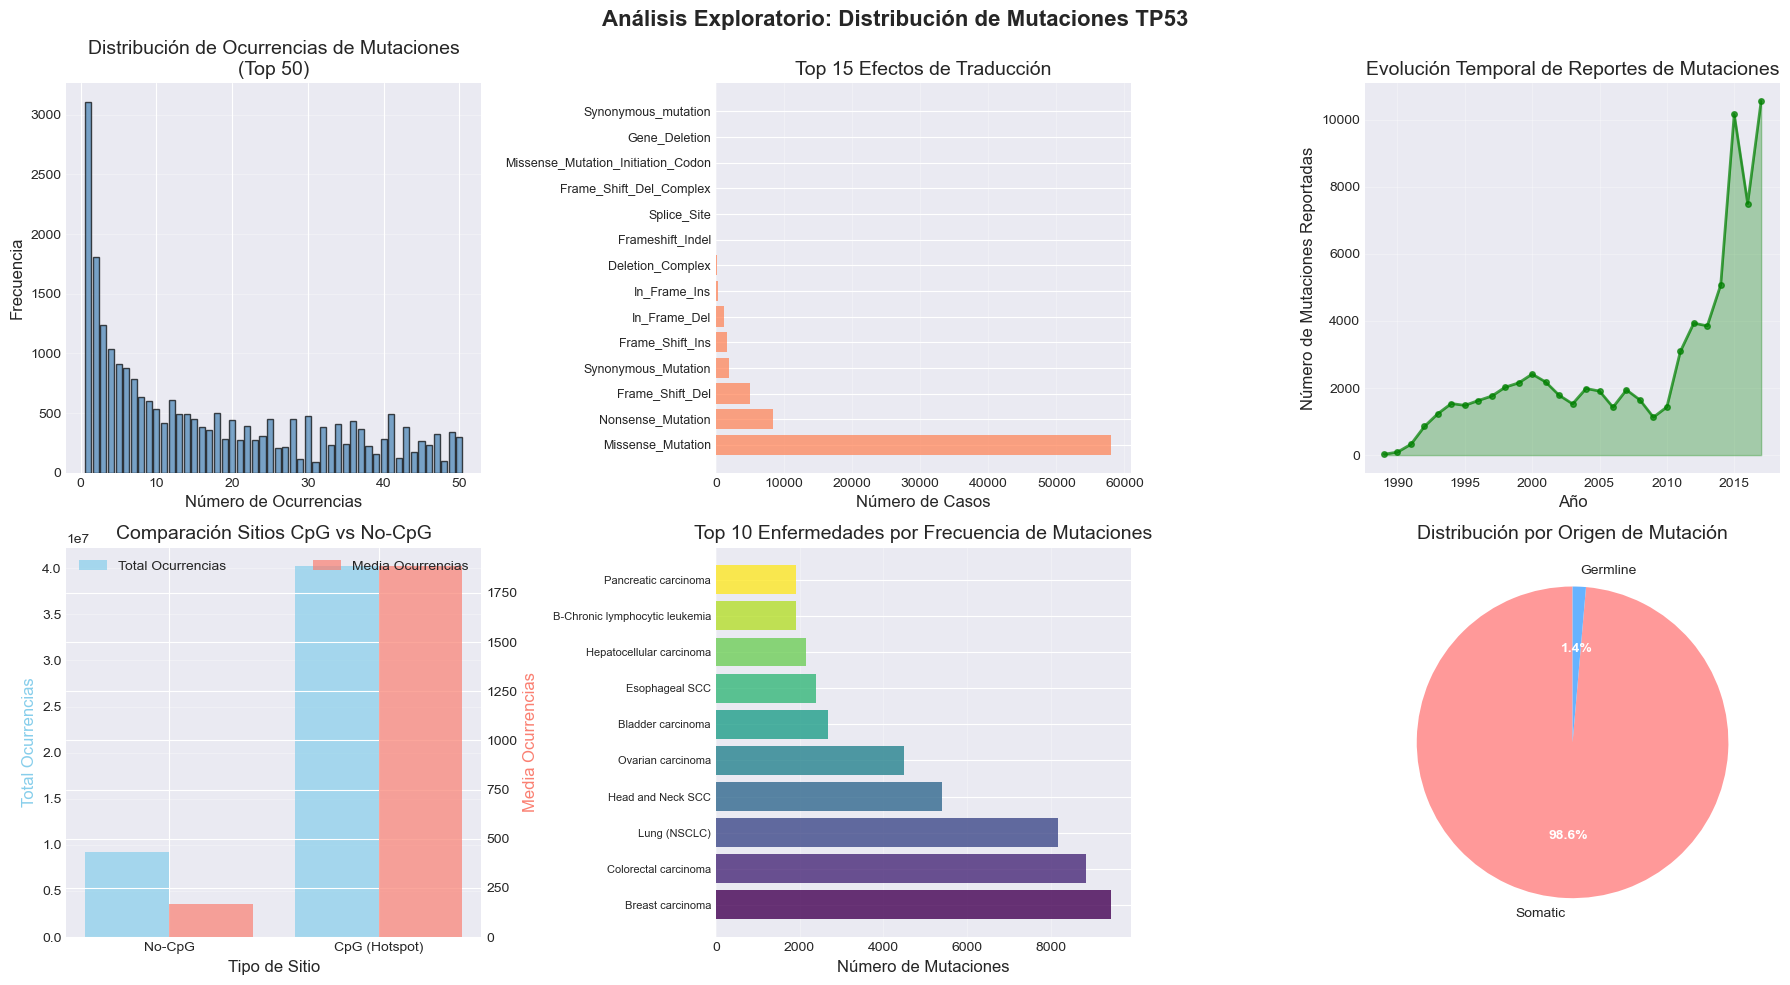


--------------------------------------------------------------------------------
ESTADÍSTICAS DESCRIPTIVAS CLAVE
--------------------------------------------------------------------------------

Total de mutaciones únicas: 76,696
Suma total de ocurrencias: 49,485,927
Tasa promedio (λ estimado global): 645.2217
Mediana de ocurrencias: 157.00
Desviación estándar: 961.7433
Coeficiente de variación: 1.4906


In [34]:
print("="*80)
print("ANÁLISIS EXPLORATORIO DE DATOS")
print("="*80)

# Configuración de subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Análisis Exploratorio: Distribución de Mutaciones TP53', 
             fontsize=16, fontweight='bold')

# 1. Distribución de frecuencias de mutaciones (clave para λ)
ax1 = axes[0, 0]
mutation_counts = df_clean['Número_Ocurrencias'].value_counts().sort_index()
ax1.bar(mutation_counts.index[:50], mutation_counts.values[:50], 
        color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Número de Ocurrencias')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Ocurrencias de Mutaciones\n(Top 50)')
ax1.grid(axis='y', alpha=0.3)

# 2. Top 15 tipos de mutación más frecuentes
ax2 = axes[0, 1]
if 'Efecto_Traducción' in df_clean.columns:
    top_mutations = df_clean['Efecto_Traducción'].value_counts().head(15)
    ax2.barh(range(len(top_mutations)), top_mutations.values, color='coral', alpha=0.7)
    ax2.set_yticks(range(len(top_mutations)))
    ax2.set_yticklabels(top_mutations.index, fontsize=9)
    ax2.set_xlabel('Número de Casos')
    ax2.set_title('Top 15 Efectos de Traducción')
    ax2.grid(axis='x', alpha=0.3)

# 3. Distribución temporal de mutaciones
ax3 = axes[0, 2]
if 'Año' in df_clean.columns:
    year_dist = df_clean['Año'].dropna().value_counts().sort_index()
    ax3.plot(year_dist.index, year_dist.values, marker='o', linewidth=2, 
             markersize=4, color='green', alpha=0.7)
    ax3.fill_between(year_dist.index, year_dist.values, alpha=0.3, color='green')
    ax3.set_xlabel('Año')
    ax3.set_ylabel('Número de Mutaciones Reportadas')
    ax3.set_title('Evolución Temporal de Reportes de Mutaciones')
    ax3.grid(True, alpha=0.3)

# 4. Comparación CpG vs No-CpG (hotspots)
ax4 = axes[1, 0]
if 'Es_Hotspot' in df_clean.columns:
    hotspot_data = df_clean.groupby('Es_Hotspot')['Número_Ocurrencias'].agg(['sum', 'mean'])
    labels = ['No-CpG', 'CpG (Hotspot)']
    x_pos = np.arange(len(labels))
    
    ax4_twin = ax4.twinx()
    bars1 = ax4.bar(x_pos - 0.2, hotspot_data['sum'], 0.4, 
                    label='Total Ocurrencias', color='skyblue', alpha=0.7)
    bars2 = ax4_twin.bar(x_pos + 0.2, hotspot_data['mean'], 0.4, 
                         label='Media Ocurrencias', color='salmon', alpha=0.7)
    
    ax4.set_xlabel('Tipo de Sitio')
    ax4.set_ylabel('Total Ocurrencias', color='skyblue')
    ax4_twin.set_ylabel('Media Ocurrencias', color='salmon')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(labels)
    ax4.set_title('Comparación Sitios CpG vs No-CpG')
    ax4.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')
    ax4.grid(axis='y', alpha=0.3)

# 5. Top 10 enfermedades con más mutaciones
ax5 = axes[1, 1]
if 'Enfermedad' in df_clean.columns:
    disease_counts = df_clean['Enfermedad'].value_counts().head(10)
    colors = plt.cm.viridis(np.linspace(0, 1, len(disease_counts)))
    ax5.barh(range(len(disease_counts)), disease_counts.values, color=colors, alpha=0.8)
    ax5.set_yticks(range(len(disease_counts)))
    ax5.set_yticklabels([label[:40] + '...' if len(label) > 40 else label 
                         for label in disease_counts.index], fontsize=8)
    ax5.set_xlabel('Número de Mutaciones')
    ax5.set_title('Top 10 Enfermedades por Frecuencia de Mutaciones')
    ax5.grid(axis='x', alpha=0.3)

# 6. Distribución por origen de mutación
ax6 = axes[1, 2]
if 'Origen' in df_clean.columns:
    origin_counts = df_clean['Origen'].value_counts()
    colors_origin = ['#ff9999', '#66b3ff', '#99ff99']
    wedges, texts, autotexts = ax6.pie(origin_counts.values, 
                                         labels=origin_counts.index,
                                         autopct='%1.1f%%',
                                         colors=colors_origin[:len(origin_counts)],
                                         startangle=90,
                                         textprops={'fontsize': 10})
    ax6.set_title('Distribución por Origen de Mutación')
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

plt.tight_layout()
plt.savefig('EDA_mutaciones_TP53.png', dpi=300, bbox_inches='tight')
plt.show()

# Estadísticas descriptivas clave
print("\n" + "-"*80)
print("ESTADÍSTICAS DESCRIPTIVAS CLAVE")
print("-"*80)
print(f"\nTotal de mutaciones únicas: {len(df_clean):,}")
print(f"Suma total de ocurrencias: {df_clean['Número_Ocurrencias'].sum():,}")
print(f"Tasa promedio (λ estimado global): {df_clean['Número_Ocurrencias'].mean():.4f}")
print(f"Mediana de ocurrencias: {df_clean['Número_Ocurrencias'].median():.2f}")
print(f"Desviación estándar: {df_clean['Número_Ocurrencias'].std():.4f}")
print(f"Coeficiente de variación: {df_clean['Número_Ocurrencias'].std()/df_clean['Número_Ocurrencias'].mean():.4f}")

# Estimación de Parámetros del Proceso de Poisson
Calculamos los parámetros fundamentales del Proceso de Poisson (tasa λ) para diferentes estratificaciones de los datos.

In [35]:
print("="*80)
print("ESTIMACIÓN DE PARÁMETROS DEL PROCESO DE POISSON")
print("="*80)

# Función para estimar lambda con intervalos de confianza
def estimate_lambda_with_ci(data, confidence=0.95):
    """
    Estima la tasa λ del proceso de Poisson con intervalos de confianza.
    
    Para un proceso de Poisson, λ se estima como la media de los datos.
    El IC se calcula usando la distribución chi-cuadrado.
    """
    n = len(data)
    lambda_est = data.mean()
    sum_x = data.sum()
    
    # Intervalos de confianza usando distribución chi-cuadrado
    alpha = 1 - confidence
    lower = stats.chi2.ppf(alpha/2, 2*sum_x) / (2*n)
    upper = stats.chi2.ppf(1-alpha/2, 2*(sum_x+1)) / (2*n)
    
    return lambda_est, lower, upper

# 1. Lambda global
print("\n[1] TASA GLOBAL (λ global)")
print("-"*80)
lambda_global, ci_lower, ci_upper = estimate_lambda_with_ci(df_clean['Número_Ocurrencias'])
print(f"λ estimado: {lambda_global:.4f}")
print(f"IC 95%: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Total de eventos: {df_clean['Número_Ocurrencias'].sum():,}")
print(f"Total de variantes únicas: {len(df_clean):,}")

# 2. Lambda por tipo de mutación
print("\n[2] TASA POR TIPO DE MUTACIÓN (λ estratificado)")
print("-"*80)
lambda_by_type = {}
if 'Clase_Mutación' in df_clean.columns:
    for mut_type in df_clean['Clase_Mutación'].unique():
        if mut_type != 'Unknown':
            subset = df_clean[df_clean['Clase_Mutación'] == mut_type]['Número_Ocurrencias']
            if len(subset) > 0:
                lambda_est, ci_l, ci_u = estimate_lambda_with_ci(subset)
                lambda_by_type[mut_type] = {
                    'lambda': lambda_est,
                    'ci_lower': ci_l,
                    'ci_upper': ci_u,
                    'n_variants': len(subset),
                    'total_events': subset.sum()
                }
                print(f"{mut_type:15s}: λ = {lambda_est:8.4f}  IC:[{ci_l:7.4f}, {ci_u:7.4f}]  n = {len(subset):,}")

# 3. Lambda para sitios CpG vs No-CpG
print("\n[3] COMPARACIÓN HOTSPOTS: CpG vs No-CpG")
print("-"*80)
if 'Es_Hotspot' in df_clean.columns:
    cpg_data = df_clean[df_clean['Es_Hotspot'] == True]['Número_Ocurrencias']
    non_cpg_data = df_clean[df_clean['Es_Hotspot'] == False]['Número_Ocurrencias']
    
    lambda_cpg, ci_l_cpg, ci_u_cpg = estimate_lambda_with_ci(cpg_data)
    lambda_non_cpg, ci_l_non, ci_u_non = estimate_lambda_with_ci(non_cpg_data)
    
    ratio = lambda_cpg / lambda_non_cpg if lambda_non_cpg > 0 else 0
    
    print(f"λ CpG (hotspot):     {lambda_cpg:8.4f}  IC:[{ci_l_cpg:7.4f}, {ci_u_cpg:7.4f}]")
    print(f"λ No-CpG:            {lambda_non_cpg:8.4f}  IC:[{ci_l_non:7.4f}, {ci_u_non:7.4f}]")
    print(f"Ratio λ_CpG/λ_No-CpG: {ratio:.2f}x")
    print(f"\nInterpretación: Los sitios CpG tienen una tasa de mutación {ratio:.1f} veces mayor")

# 4. Lambda por enfermedad (top 10)
print("\n[4] TASA POR ENFERMEDAD (top 10)")
print("-"*80)
if 'Enfermedad' in df_clean.columns:
    top_diseases = df_clean['Enfermedad'].value_counts().head(10).index
    lambda_by_disease = {}
    
    for disease in top_diseases:
        subset = df_clean[df_clean['Enfermedad'] == disease]['Número_Ocurrencias']
        if len(subset) >= 10:  # Mínimo 10 observaciones para estimar
            lambda_est, ci_l, ci_u = estimate_lambda_with_ci(subset)
            lambda_by_disease[disease] = lambda_est
            disease_short = disease[:50] + '...' if len(disease) > 50 else disease
            print(f"{disease_short:52s}: λ = {lambda_est:8.4f}  n = {len(subset):,}")

# 5. Lambda temporal (por año)
print("\n[5] EVOLUCIÓN TEMPORAL DE λ")
print("-"*80)
if 'Año' in df_clean.columns:
    year_lambda = {}
    valid_years = df_clean[df_clean['Año'].notna() & (df_clean['Año'] >= 1990)]
    
    for year in sorted(valid_years['Año'].unique()):
        subset = valid_years[valid_years['Año'] == year]['Número_Ocurrencias']
        if len(subset) >= 5:
            lambda_est, _, _ = estimate_lambda_with_ci(subset)
            year_lambda[year] = lambda_est
    
    if len(year_lambda) > 0:
        print(f"Años analizados: {len(year_lambda)}")
        print(f"Rango: {min(year_lambda.keys())} - {max(year_lambda.keys())}")
        print(f"λ promedio temporal: {np.mean(list(year_lambda.values())):.4f}")
        print(f"Tendencia: {'Creciente' if list(year_lambda.values())[-1] > list(year_lambda.values())[0] else 'Decreciente'}")

# Guardar resultados
results_summary = {
    'lambda_global': lambda_global,
    'lambda_by_type': lambda_by_type,
    'lambda_cpg': lambda_cpg if 'Es_Hotspot' in df_clean.columns else None,
    'lambda_non_cpg': lambda_non_cpg if 'Es_Hotspot' in df_clean.columns else None
}

print("\n✓ Parámetros estimados correctamente")

ESTIMACIÓN DE PARÁMETROS DEL PROCESO DE POISSON

[1] TASA GLOBAL (λ global)
--------------------------------------------------------------------------------
λ estimado: 645.2217
IC 95%: [645.0420, 645.4015]
Total de eventos: 49,485,927
Total de variantes únicas: 76,696

[2] TASA POR TIPO DE MUTACIÓN (λ estratificado)
--------------------------------------------------------------------------------
D              : λ =  18.4007  IC:[18.2947, 18.5072]  n = 6,274
I              : λ =   3.9153  IC:[ 3.8261,  4.0062]  n = 1,866
B              : λ = 729.7722  IC:[729.5686, 729.9758]  n = 67,632
ID             : λ =   7.8171  IC:[ 7.6379,  7.9995]  n = 924

[3] COMPARACIÓN HOTSPOTS: CpG vs No-CpG
--------------------------------------------------------------------------------
λ CpG (hotspot):     1886.5726  IC:[1885.9896, 1887.1557]
λ No-CpG:            167.2652  IC:[167.1575, 167.3730]
Ratio λ_CpG/λ_No-CpG: 11.28x

Interpretación: Los sitios CpG tienen una tasa de mutación 11.3 veces mayor

[

# Validación del Modelo de Poisson
Validamos si los datos siguen efectivamente un Proceso de Poisson mediante pruebas estadísticas formales y análisis de bondad de ajuste.

VALIDACIÓN DEL MODELO DE POISSON

[1] TEST DE BONDAD DE AJUSTE GLOBAL
--------------------------------------------------------------------------------
λ estimado: 645.2217
Estadístico χ²: 0.0000
Grados de libertad: -1
Valor p: nan
Conclusión: NO RECHAZAR H0 - Compatible con Poisson

[2] TEST PARA MUTACIONES SOMÁTICAS
--------------------------------------------------------------------------------
n = 75,643 mutaciones somáticas
λ estimado: 644.1496
Valor p: nan
Conclusión: NO RECHAZAR H0

[3] TEST DE EQUIDISPERSIÓN
--------------------------------------------------------------------------------
Media: 645.2217
Varianza: 924950.2666
Índice de dispersión (Var/Media): 1433.5386

Interpretación:
  ⚠ Sobredispersión detectada (varianza > media)
  → Considerar Binomial Negativa o Poisson Compuesto


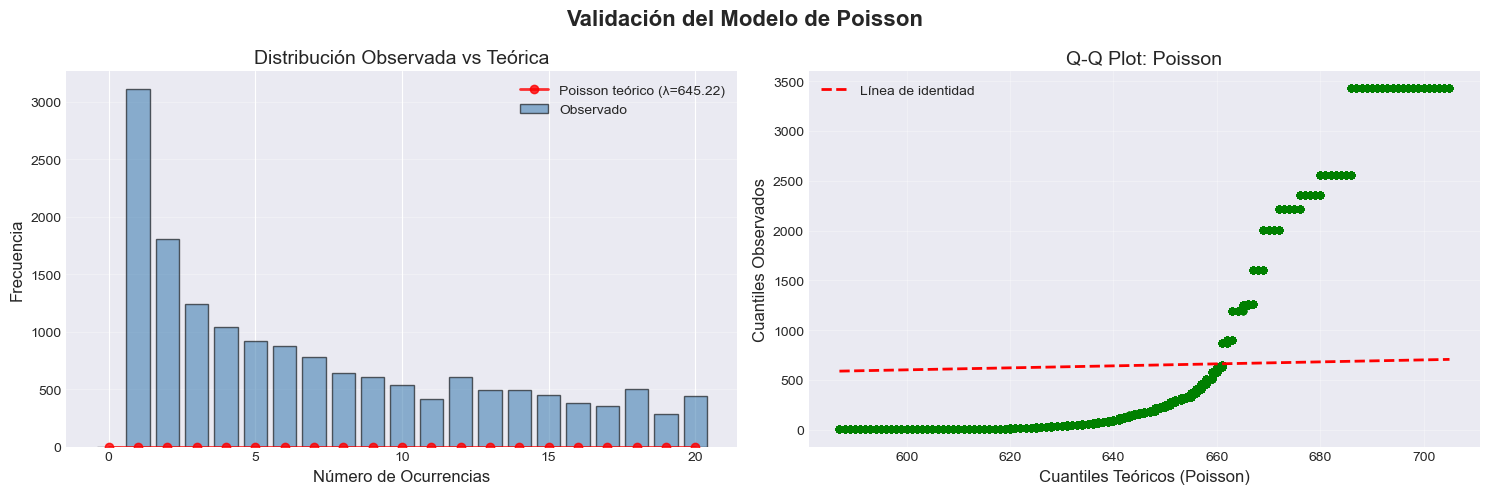


✓ Validación completada


In [36]:
print("="*80)
print("VALIDACIÓN DEL MODELO DE POISSON")
print("="*80)

# Función para test de bondad de ajuste
def poisson_goodness_of_fit(observed_data, alpha=0.05):
    """
    Realiza test chi-cuadrado de bondad de ajuste para distribución de Poisson.
    """
    # Estimar lambda
    lambda_est = observed_data.mean()
    
    # Crear tabla de frecuencias observadas
    value_counts = observed_data.value_counts().sort_index()
    
    # Limitar a valores razonables para el test
    max_val = min(int(value_counts.index.max()), 20)
    obs_freq = np.zeros(max_val + 2)
    
    for val, freq in value_counts.items():
        if val <= max_val:
            obs_freq[int(val)] = freq
        else:
            obs_freq[-1] += freq  # Agrupar valores grandes
    
    # Calcular frecuencias esperadas bajo Poisson
    n = len(observed_data)
    exp_freq = np.zeros(max_val + 2)
    
    for k in range(max_val + 1):
        exp_freq[k] = n * poisson.pmf(k, lambda_est)
    
    # Resto en última categoría
    exp_freq[-1] = n * (1 - poisson.cdf(max_val, lambda_est))
    
    # Combinar categorías con frecuencias esperadas bajas (< 5)
    obs_combined = []
    exp_combined = []
    temp_obs = 0
    temp_exp = 0
    
    for obs, exp in zip(obs_freq, exp_freq):
        temp_obs += obs
        temp_exp += exp
        if temp_exp >= 5:
            obs_combined.append(temp_obs)
            exp_combined.append(temp_exp)
            temp_obs = 0
            temp_exp = 0
    
    if temp_obs > 0:
        obs_combined[-1] += temp_obs
        exp_combined[-1] += temp_exp
    
    # Test chi-cuadrado
    chi2_stat = np.sum((np.array(obs_combined) - np.array(exp_combined))**2 / np.array(exp_combined))
    df = len(obs_combined) - 2  # -1 por estimación de lambda, -1 por suma = n
    p_value = 1 - stats.chi2.cdf(chi2_stat, df)
    
    return {
        'chi2_statistic': chi2_stat,
        'degrees_of_freedom': df,
        'p_value': p_value,
        'lambda_est': lambda_est,
        'reject_H0': p_value < alpha
    }

# 1. Test global
print("\n[1] TEST DE BONDAD DE AJUSTE GLOBAL")
print("-"*80)
global_test = poisson_goodness_of_fit(df_clean['Número_Ocurrencias'])
print(f"λ estimado: {global_test['lambda_est']:.4f}")
print(f"Estadístico χ²: {global_test['chi2_statistic']:.4f}")
print(f"Grados de libertad: {global_test['degrees_of_freedom']}")
print(f"Valor p: {global_test['p_value']:.4f}")
print(f"Conclusión: {'RECHAZAR H0 - No sigue Poisson' if global_test['reject_H0'] else 'NO RECHAZAR H0 - Compatible con Poisson'}")

# 2. Test para mutaciones somáticas
print("\n[2] TEST PARA MUTACIONES SOMÁTICAS")
print("-"*80)
if 'Origen' in df_clean.columns:
    somatic_data = df_clean[df_clean['Origen'].str.contains('Somatic', na=False)]['Número_Ocurrencias']
    if len(somatic_data) > 30:
        somatic_test = poisson_goodness_of_fit(somatic_data)
        print(f"n = {len(somatic_data):,} mutaciones somáticas")
        print(f"λ estimado: {somatic_test['lambda_est']:.4f}")
        print(f"Valor p: {somatic_test['p_value']:.4f}")
        print(f"Conclusión: {'RECHAZAR H0' if somatic_test['reject_H0'] else 'NO RECHAZAR H0'}")

# 3. Test de equidispersión (Índice de dispersión)
print("\n[3] TEST DE EQUIDISPERSIÓN")
print("-"*80)
data = df_clean['Número_Ocurrencias']
mean_val = data.mean()
var_val = data.var()
dispersion_index = var_val / mean_val if mean_val > 0 else 0

print(f"Media: {mean_val:.4f}")
print(f"Varianza: {var_val:.4f}")
print(f"Índice de dispersión (Var/Media): {dispersion_index:.4f}")
print(f"\nInterpretación:")
if abs(dispersion_index - 1.0) < 0.1:
    print("  ✓ Equidispersión perfecta (compatible con Poisson)")
elif dispersion_index > 1.5:
    print("  ⚠ Sobredispersión detectada (varianza > media)")
    print("  → Considerar Binomial Negativa o Poisson Compuesto")
else:
    print("  ⚠ Subdispersión detectada (varianza < media)")
    print("  → Posible efecto de truncamiento o restricciones")

# 4. Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Validación del Modelo de Poisson', fontsize=16, fontweight='bold')

# Histograma vs distribución teórica
ax1 = axes[0]
observed_counts = data.value_counts().sort_index()
max_plot = min(20, observed_counts.index.max())
x_vals = range(max_plot + 1)

# Frecuencias observadas
obs_freq_plot = [observed_counts.get(x, 0) for x in x_vals]
ax1.bar(x_vals, obs_freq_plot, alpha=0.6, label='Observado', color='steelblue', edgecolor='black')

# Frecuencias esperadas (Poisson teórico)
lambda_est = data.mean()
exp_freq_plot = [len(data) * poisson.pmf(x, lambda_est) for x in x_vals]
ax1.plot(x_vals, exp_freq_plot, 'r-o', linewidth=2, markersize=6, 
         label=f'Poisson teórico (λ={lambda_est:.2f})', alpha=0.8)

ax1.set_xlabel('Número de Ocurrencias')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución Observada vs Teórica')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Q-Q plot
ax2 = axes[1]
sample_sorted = np.sort(data)
theoretical_quantiles = poisson.ppf(np.linspace(0.01, 0.99, len(sample_sorted)), lambda_est)

ax2.scatter(theoretical_quantiles, sample_sorted, alpha=0.5, s=20, color='green')
ax2.plot([theoretical_quantiles.min(), theoretical_quantiles.max()],
         [theoretical_quantiles.min(), theoretical_quantiles.max()],
         'r--', linewidth=2, label='Línea de identidad')
ax2.set_xlabel('Cuantiles Teóricos (Poisson)')
ax2.set_ylabel('Cuantiles Observados')
ax2.set_title('Q-Q Plot: Poisson')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('validacion_poisson.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Validación completada")

# Modelado de Procesos de Poisson No Homogéneos
Modelamos procesos de Poisson con tasa variable en el tiempo, identificando tendencias y cambios en la intensidad mutacional.


MODELADO DE PROCESOS DE POISSON NO HOMOGÉNEOS

[1] ESTADÍSTICAS TEMPORALES
--------------------------------------------------------------------------------
Período analizado: 1990 - 2017
Años con datos: 28
Total eventos acumulados: 49,459,116
Promedio eventos/año: 1766397.00

[2] MODELO DE TENDENCIA LINEAL: λ(t) = a + b·t
--------------------------------------------------------------------------------
Intercepto (a): 2210.3449
Pendiente (b): -0.783988
R²: 0.0107
Valor p: 0.6001

○ No hay tendencia temporal significativa

[3] PROYECCIÓN λ(t) para próximos 5 años
--------------------------------------------------------------------------------
Año 2018: λ proyectado = 628.2563
Año 2019: λ proyectado = 627.4723
Año 2020: λ proyectado = 626.6883
Año 2021: λ proyectado = 625.9044
Año 2022: λ proyectado = 625.1204


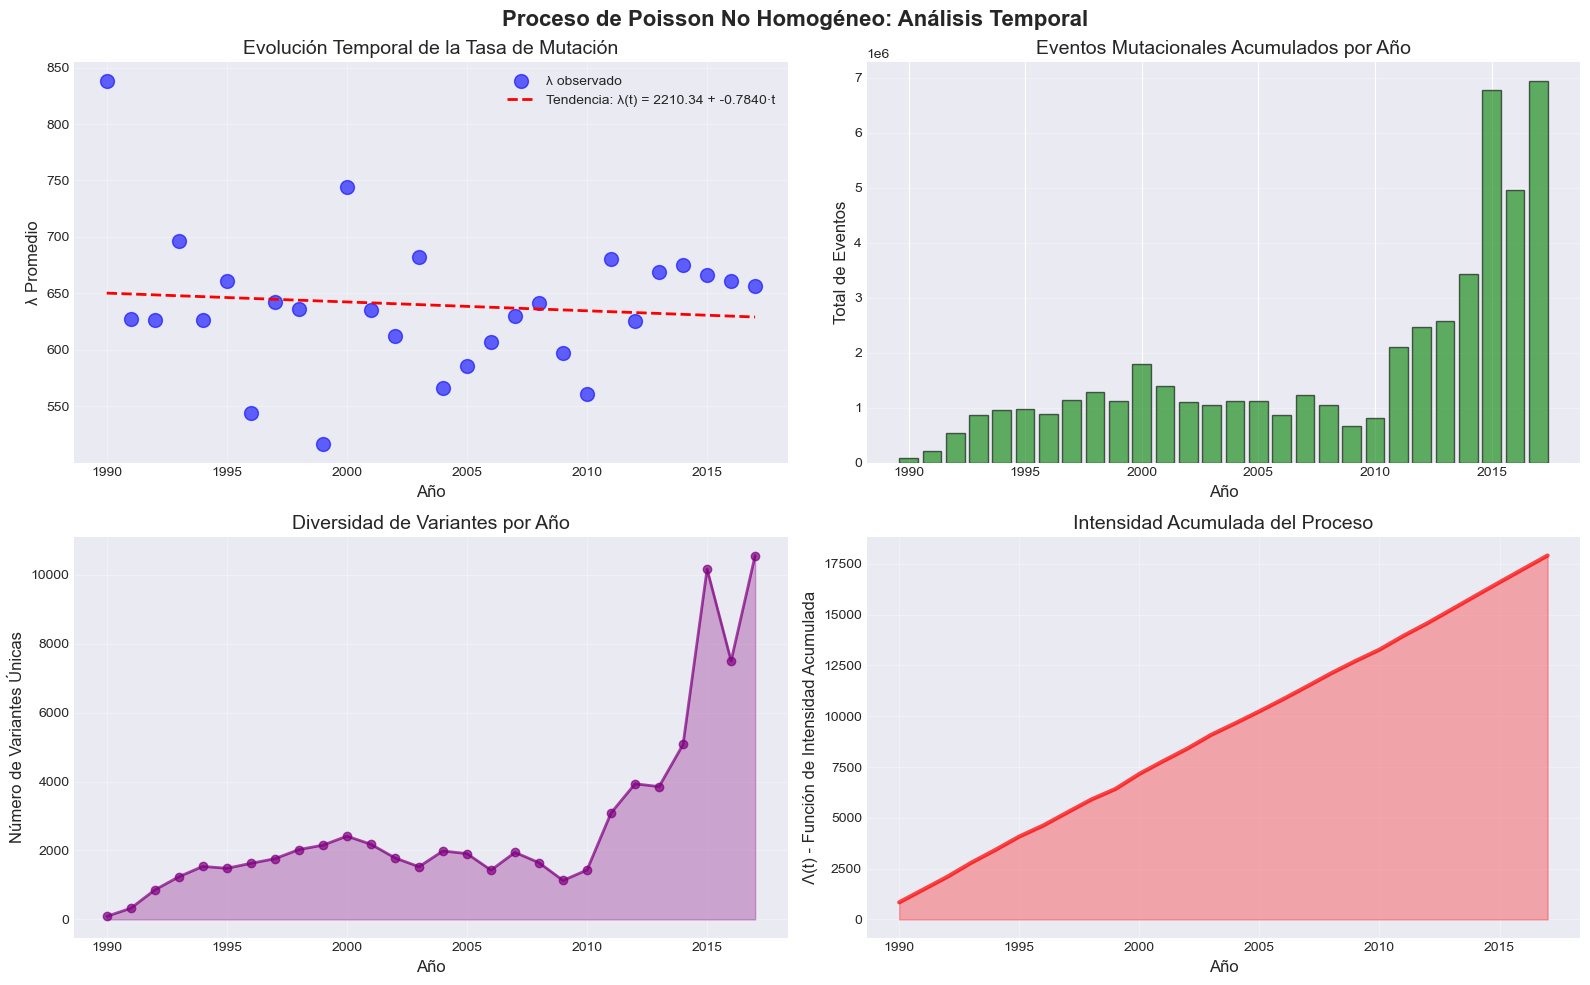


✓ Modelado temporal completado


In [37]:
print("="*80)
print("MODELADO DE PROCESOS DE POISSON NO HOMOGÉNEOS")
print("="*80)

# Preparar datos temporales
if 'Año' in df_clean.columns:
    temporal_data = df_clean[df_clean['Año'].notna() & (df_clean['Año'] >= 1990)].copy()
    
    # Agrupar por año
    yearly_summary = temporal_data.groupby('Año').agg({
        'Número_Ocurrencias': ['sum', 'mean', 'count']
    }).reset_index()
    yearly_summary.columns = ['Año', 'Total_Eventos', 'Lambda_Promedio', 'Num_Variantes']
    
    print("\n[1] ESTADÍSTICAS TEMPORALES")
    print("-"*80)
    print(f"Período analizado: {int(yearly_summary['Año'].min())} - {int(yearly_summary['Año'].max())}")
    print(f"Años con datos: {len(yearly_summary)}")
    print(f"Total eventos acumulados: {yearly_summary['Total_Eventos'].sum():,}")
    print(f"Promedio eventos/año: {yearly_summary['Total_Eventos'].mean():.2f}")
    
    # Modelo de tendencia: λ(t) = a + b*t
    from scipy.stats import linregress
    
    print("\n[2] MODELO DE TENDENCIA LINEAL: λ(t) = a + b·t")
    print("-"*80)
    
    years_numeric = yearly_summary['Año'].values
    lambda_values = yearly_summary['Lambda_Promedio'].values
    
    slope, intercept, r_value, p_value, std_err = linregress(years_numeric, lambda_values)
    
    print(f"Intercepto (a): {intercept:.4f}")
    print(f"Pendiente (b): {slope:.6f}")
    print(f"R²: {r_value**2:.4f}")
    print(f"Valor p: {p_value:.4f}")
    
    if p_value < 0.05:
        if slope > 0:
            print(f"\n✓ Tendencia CRECIENTE significativa")
            print(f"  λ aumenta {slope:.6f} unidades por año")
        else:
            print(f"\n✓ Tendencia DECRECIENTE significativa")
            print(f"  λ disminuye {abs(slope):.6f} unidades por año")
    else:
        print(f"\n○ No hay tendencia temporal significativa")
    
    # Proyección para los próximos 5 años
    print("\n[3] PROYECCIÓN λ(t) para próximos 5 años")
    print("-"*80)
    current_year = int(yearly_summary['Año'].max())
    future_years = range(current_year + 1, current_year + 6)
    
    for year in future_years:
        lambda_projected = intercept + slope * year
        print(f"Año {year}: λ proyectado = {lambda_projected:.4f}")
    
    # Visualización del proceso no homogéneo
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Proceso de Poisson No Homogéneo: Análisis Temporal', 
                 fontsize=16, fontweight='bold')
    
    # 1. Evolución de λ con tendencia
    ax1 = axes[0, 0]
    ax1.scatter(yearly_summary['Año'], yearly_summary['Lambda_Promedio'], 
                s=100, alpha=0.6, color='blue', label='λ observado')
    
    # Línea de tendencia
    years_extended = np.linspace(yearly_summary['Año'].min(), 
                                  yearly_summary['Año'].max(), 100)
    lambda_trend = intercept + slope * years_extended
    ax1.plot(years_extended, lambda_trend, 'r--', linewidth=2, 
             label=f'Tendencia: λ(t) = {intercept:.2f} + {slope:.4f}·t')
    
    ax1.set_xlabel('Año')
    ax1.set_ylabel('λ Promedio')
    ax1.set_title('Evolución Temporal de la Tasa de Mutación')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Total de eventos por año
    ax2 = axes[0, 1]
    ax2.bar(yearly_summary['Año'], yearly_summary['Total_Eventos'], 
            color='green', alpha=0.6, edgecolor='black')
    ax2.set_xlabel('Año')
    ax2.set_ylabel('Total de Eventos')
    ax2.set_title('Eventos Mutacionales Acumulados por Año')
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Número de variantes reportadas
    ax3 = axes[1, 0]
    ax3.plot(yearly_summary['Año'], yearly_summary['Num_Variantes'], 
             marker='o', linewidth=2, markersize=6, color='purple', alpha=0.7)
    ax3.fill_between(yearly_summary['Año'], yearly_summary['Num_Variantes'], 
                     alpha=0.3, color='purple')
    ax3.set_xlabel('Año')
    ax3.set_ylabel('Número de Variantes Únicas')
    ax3.set_title('Diversidad de Variantes por Año')
    ax3.grid(True, alpha=0.3)
    
    # 4. Tasa acumulativa (función de intensidad integrada)
    ax4 = axes[1, 1]
    cumulative_lambda = np.cumsum(yearly_summary['Lambda_Promedio'].values)
    ax4.plot(yearly_summary['Año'], cumulative_lambda, 
             linewidth=3, color='red', alpha=0.7)
    ax4.fill_between(yearly_summary['Año'], cumulative_lambda, 
                     alpha=0.3, color='red')
    ax4.set_xlabel('Año')
    ax4.set_ylabel('Λ(t) - Función de Intensidad Acumulada')
    ax4.set_title('Intensidad Acumulada del Proceso')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('poisson_no_homogeneo.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Modelado temporal completado")
    
else:
    print("\n⚠ Variable temporal no disponible para análisis")

# Análisis de Hotspots Mutacionales
Identificamos y caracterizamos regiones genómicas con tasas de mutación significativamente elevadas (hotspots), fundamentales para comprender la heterogeneidad espacial del proceso.

ANÁLISIS DE HOTSPOTS MUTACIONALES

[1] ESTADÍSTICAS GENERALES
--------------------------------------------------------------------------------
Codones analizados: 370
Rango: 1 - 393
Media de mutaciones/codón: 133745.75
Mediana de mutaciones/codón: 653.00

[2] IDENTIFICACIÓN DE HOTSPOTS
--------------------------------------------------------------------------------
Hotspots identificados (p95): 19
Threshold p95: 186324 mutaciones
Threshold p99: 2044519 mutaciones

[3] TOP 20 HOTSPOTS MUTACIONALES
--------------------------------------------------------------------------------
   Codón   Total_Mut   Variantes      Lambda               Dominio
--------------------------------------------------------------------------------
     175    11757142        3728     3153.74  HCD III - DNA bindin
     273    10689830        5303     2015.81   HCD V - DNA binding
     248    10667383        5114     2085.92  HCD IV - DNA binding
     282     2599549        1965     1322.93   HCD V - DNA binding
 

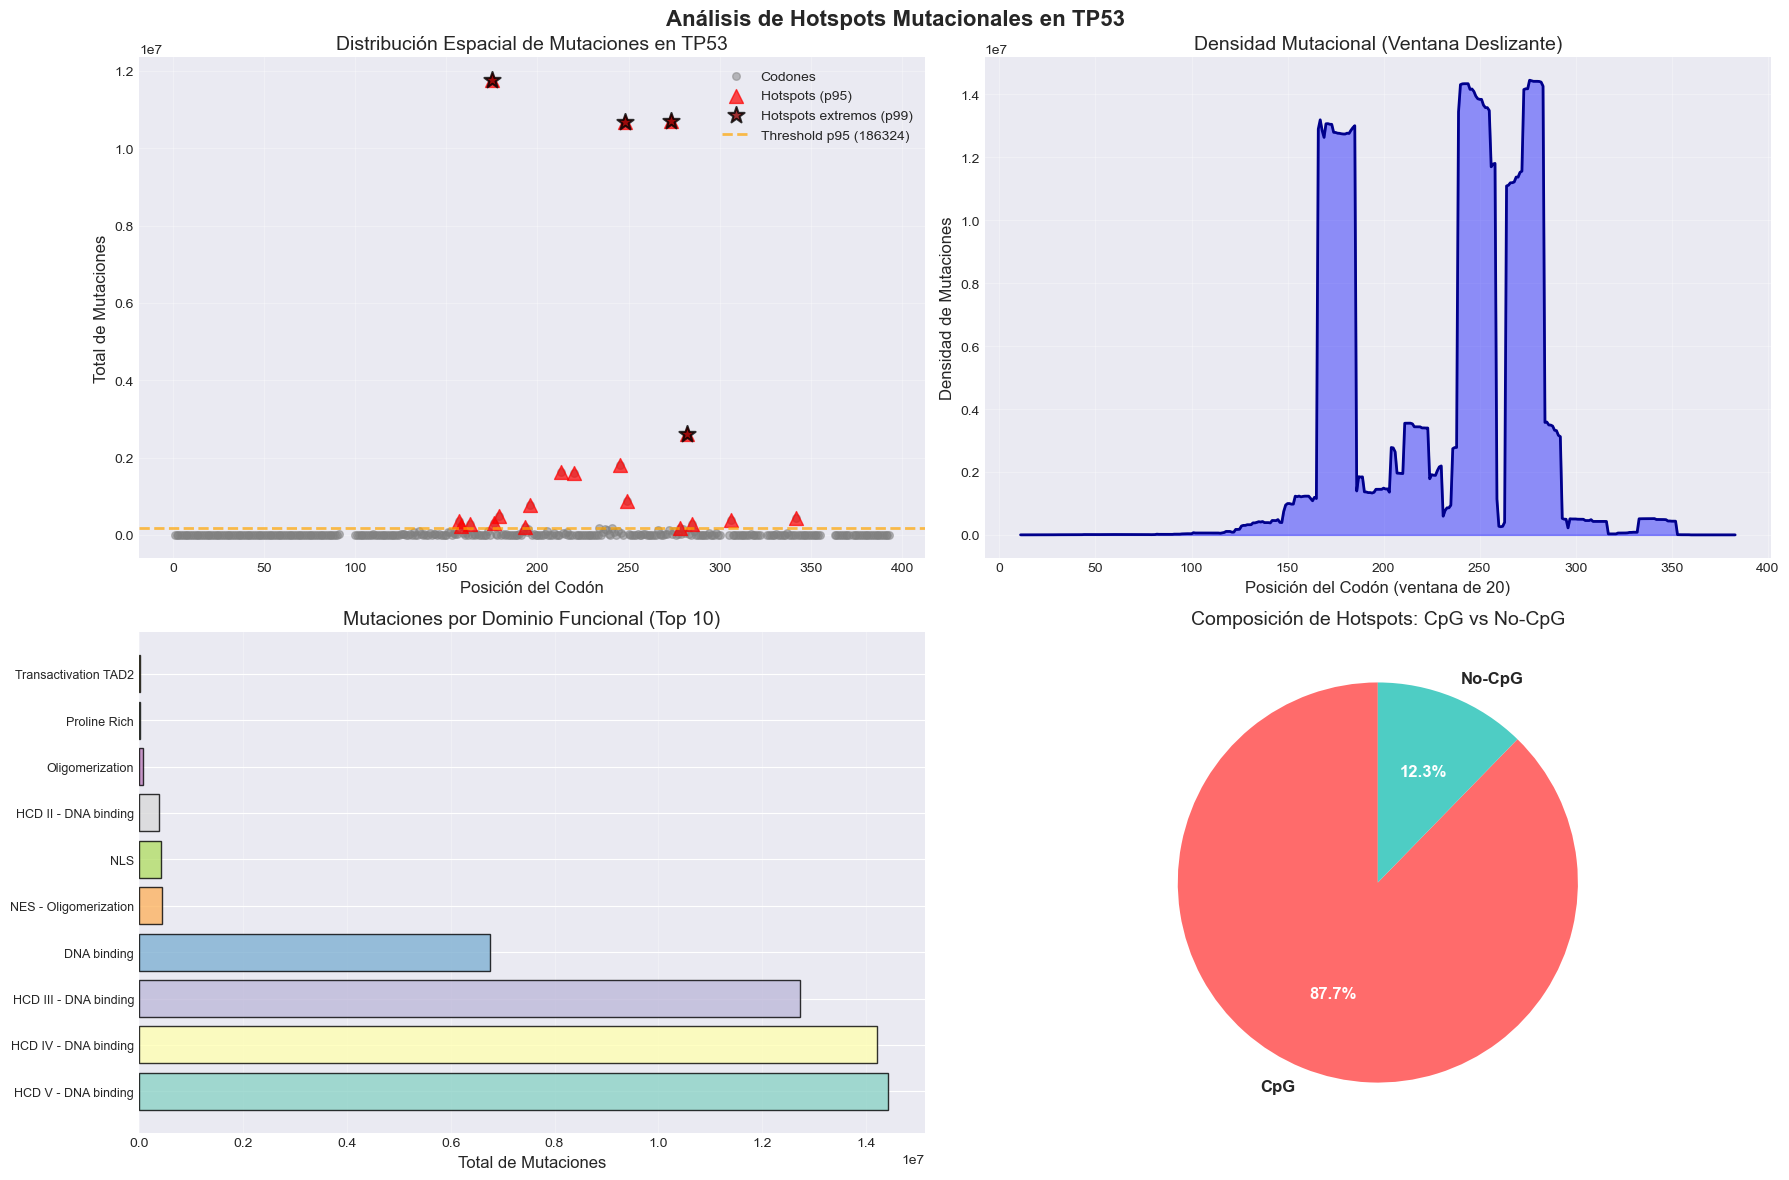


✓ Análisis de hotspots completado


In [38]:
print("="*80)
print("ANÁLISIS DE HOTSPOTS MUTACIONALES")
print("="*80)

# Análisis por codón
if 'Codón' in df_clean.columns:
    # Procesar codones
    codon_data = df_clean.copy()
    codon_data['Codón'] = pd.to_numeric(codon_data['Codón'], errors='coerce')
    codon_data = codon_data[codon_data['Codón'].notna() & 
                            (codon_data['Codón'] >= 1) & 
                            (codon_data['Codón'] <= 393)]
    
    # Agrupar por codón
    codon_summary = codon_data.groupby('Codón').agg({
        'Número_Ocurrencias': ['sum', 'count', 'mean']
    }).reset_index()
    codon_summary.columns = ['Codón', 'Total_Mutaciones', 'Num_Variantes', 'Lambda_Promedio']
    
    # Calcular percentiles para definir hotspots
    threshold_95 = codon_summary['Total_Mutaciones'].quantile(0.95)
    threshold_99 = codon_summary['Total_Mutaciones'].quantile(0.99)
    
    codon_summary['Es_Hotspot'] = codon_summary['Total_Mutaciones'] >= threshold_95
    codon_summary['Es_Hotspot_Extremo'] = codon_summary['Total_Mutaciones'] >= threshold_99
    
    print("\n[1] ESTADÍSTICAS GENERALES")
    print("-"*80)
    print(f"Codones analizados: {len(codon_summary)}")
    print(f"Rango: {int(codon_summary['Codón'].min())} - {int(codon_summary['Codón'].max())}")
    print(f"Media de mutaciones/codón: {codon_summary['Total_Mutaciones'].mean():.2f}")
    print(f"Mediana de mutaciones/codón: {codon_summary['Total_Mutaciones'].median():.2f}")
    
    print("\n[2] IDENTIFICACIÓN DE HOTSPOTS")
    print("-"*80)
    hotspots = codon_summary[codon_summary['Es_Hotspot']].sort_values(
        'Total_Mutaciones', ascending=False
    )
    print(f"Hotspots identificados (p95): {len(hotspots)}")
    print(f"Threshold p95: {threshold_95:.0f} mutaciones")
    print(f"Threshold p99: {threshold_99:.0f} mutaciones")
    
    print("\n[3] TOP 20 HOTSPOTS MUTACIONALES")
    print("-"*80)
    print(f"{'Codón':>8}  {'Total_Mut':>10}  {'Variantes':>10}  {'Lambda':>10}  {'Dominio':>20}")
    print("-"*80)
    
    top_hotspots = codon_summary.nlargest(20, 'Total_Mutaciones')
    for _, row in top_hotspots.iterrows():
        codon = int(row['Codón'])
        # Buscar dominio del codón
        domain = df_clean[df_clean['Codón'] == str(codon)]['Dominio_Funcional'].mode()
        domain_str = domain.iloc[0] if len(domain) > 0 else 'Unknown'
        domain_str = domain_str[:20] if isinstance(domain_str, str) else 'Unknown'
        
        print(f"{codon:>8}  {row['Total_Mutaciones']:>10.0f}  "
              f"{row['Num_Variantes']:>10.0f}  {row['Lambda_Promedio']:>10.2f}  "
              f"{domain_str:>20}")
    
    # Análisis por dominio funcional
    if 'Dominio_Funcional' in df_clean.columns:
        print("\n[4] TASA DE MUTACIÓN POR DOMINIO FUNCIONAL")
        print("-"*80)
        
        domain_summary = df_clean.groupby('Dominio_Funcional').agg({
            'Número_Ocurrencias': ['sum', 'count', 'mean']
        }).reset_index()
        domain_summary.columns = ['Dominio', 'Total_Mutaciones', 'Num_Variantes', 'Lambda_Media']
        domain_summary = domain_summary.sort_values('Total_Mutaciones', ascending=False)
        
        print(f"{'Dominio':>30}  {'Total_Mut':>12}  {'Variantes':>10}  {'Lambda':>10}")
        print("-"*80)
        for _, row in domain_summary.head(15).iterrows():
            domain = row['Dominio'][:30] if isinstance(row['Dominio'], str) else 'Unknown'
            print(f"{domain:>30}  {row['Total_Mutaciones']:>12.0f}  "
                  f"{row['Num_Variantes']:>10.0f}  {row['Lambda_Media']:>10.2f}")
    
    # Visualización de hotspots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Análisis de Hotspots Mutacionales en TP53', 
                 fontsize=16, fontweight='bold')

    # Limpiar valores '?' antes del gráfico
    codon_summary['Total_Mutaciones'] = pd.to_numeric(codon_summary['Total_Mutaciones'], errors='coerce')
    codon_summary = codon_summary.dropna(subset=['Total_Mutaciones'])
    
    # 1. Distribución espacial de mutaciones
    ax1 = axes[0, 0]
    ax1.scatter(codon_summary['Codón'], codon_summary['Total_Mutaciones'], 
                s=30, alpha=0.5, color='gray', label='Codones')
    
    hotspot_data = codon_summary[codon_summary['Es_Hotspot']]
    ax1.scatter(hotspot_data['Codón'], hotspot_data['Total_Mutaciones'], 
                s=100, alpha=0.7, color='red', label='Hotspots (p95)', marker='^')
    
    extreme_hotspot = codon_summary[codon_summary['Es_Hotspot_Extremo']]
    
    if len(extreme_hotspot) > 0:
        ax1.scatter(extreme_hotspot['Codón'], extreme_hotspot['Total_Mutaciones'], 
                    s=150, alpha=0.8, color='darkred', label='Hotspots extremos (p99)', 
                    marker='*', edgecolors='black', linewidths=1.5)
    
    ax1.axhline(y=threshold_95, color='orange', linestyle='--', 
                linewidth=2, alpha=0.7, label=f'Threshold p95 ({threshold_95:.0f})')
    ax1.set_xlabel('Posición del Codón')
    ax1.set_ylabel('Total de Mutaciones')
    ax1.set_title('Distribución Espacial de Mutaciones en TP53')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Densidad de mutaciones (ventana deslizante)
    ax2 = axes[0, 1]
    window_size = 20
    density = []
    positions = []
    
    for pos in range(1, 394 - window_size):
        window_data = codon_summary[
            (codon_summary['Codón'] >= pos) & 
            (codon_summary['Codón'] < pos + window_size)
        ]
        density.append(window_data['Total_Mutaciones'].sum())
        positions.append(pos + window_size // 2)
    
    ax2.fill_between(positions, density, alpha=0.4, color='blue')
    ax2.plot(positions, density, linewidth=2, color='darkblue')
    ax2.set_xlabel('Posición del Codón (ventana de 20)')
    ax2.set_ylabel('Densidad de Mutaciones')
    ax2.set_title('Densidad Mutacional (Ventana Deslizante)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Distribución por dominio funcional
    ax3 = axes[1, 0]
    if 'Dominio_Funcional' in df_clean.columns:
        top_domains = domain_summary.head(10)
        colors = plt.cm.Set3(np.linspace(0, 1, len(top_domains)))
        
        bars = ax3.barh(range(len(top_domains)), top_domains['Total_Mutaciones'], 
                        color=colors, alpha=0.8, edgecolor='black')
        ax3.set_yticks(range(len(top_domains)))
        ax3.set_yticklabels([d[:35] for d in top_domains['Dominio']], fontsize=9)
        ax3.set_xlabel('Total de Mutaciones')
        ax3.set_title('Mutaciones por Dominio Funcional (Top 10)')
        ax3.grid(axis='x', alpha=0.3)
    
    # 4. Comparación CpG vs No-CpG en hotspots
    ax4 = axes[1, 1]
    if 'Sitio_CpG' in df_clean.columns:
        # Filtrar datos de hotspots
        hotspot_codons = top_hotspots['Codón'].astype(int).tolist()
        hotspot_mutations = df_clean[df_clean['Codón'].astype(str).astype(float).astype(int).isin(hotspot_codons)]
        
        cpg_in_hotspots = hotspot_mutations[hotspot_mutations['Sitio_CpG'].str.lower() == 'yes']['Número_Ocurrencias'].sum()
        non_cpg_in_hotspots = hotspot_mutations[hotspot_mutations['Sitio_CpG'].str.lower() != 'yes']['Número_Ocurrencias'].sum()
        
        categories = ['CpG', 'No-CpG']
        values = [cpg_in_hotspots, non_cpg_in_hotspots]
        colors_pie = ['#ff6b6b', '#4ecdc4']
        
        wedges, texts, autotexts = ax4.pie(values, labels=categories, autopct='%1.1f%%',
                                            colors=colors_pie, startangle=90,
                                            textprops={'fontsize': 12, 'weight': 'bold'})
        ax4.set_title('Composición de Hotspots: CpG vs No-CpG')
        
        for autotext in autotexts:
            autotext.set_color('white')
    
    plt.tight_layout()
    plt.savefig('hotspots_mutacionales.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Análisis de hotspots completado")
    
else:
    print("\n⚠ Variable Codón no disponible para análisis espacial")

# Modelado de Procesos de Poisson Compuestos 
Analizamos la presencia de múltiples mutaciones en el mismo tumor, modelando procesos de Poisson compuestos donde cada evento puede generar sub-eventos.

MODELADO DE PROCESOS DE POISSON COMPUESTOS

[1] DISTRIBUCIÓN DE COMPLEJIDAD MUTACIONAL
--------------------------------------------------------------------------------
                Tipo    Frecuencia    Porcentaje
--------------------------------------------------------------------------------
                  SM        64,422        84.00%
                 DMU         8,894        11.60%
                  MM         3,229         4.21%
                 DMD           117         0.15%
                 DMS            34         0.04%

[2] ANÁLISIS DE MUTACIONES MÚLTIPLES
--------------------------------------------------------------------------------
Total de casos con mutaciones múltiples: 12,274
Porcentaje del total: 16.00%

λ para mutaciones simples (SM): 689.7615
λ para mutaciones múltiples: 411.4481
Ratio λ_múltiple/λ_simple: 0.60

[3] DISTRIBUCIÓN DE REPETICIONES EN TUMORES
--------------------------------------------------------------------------------
 Número_Mutaciones     

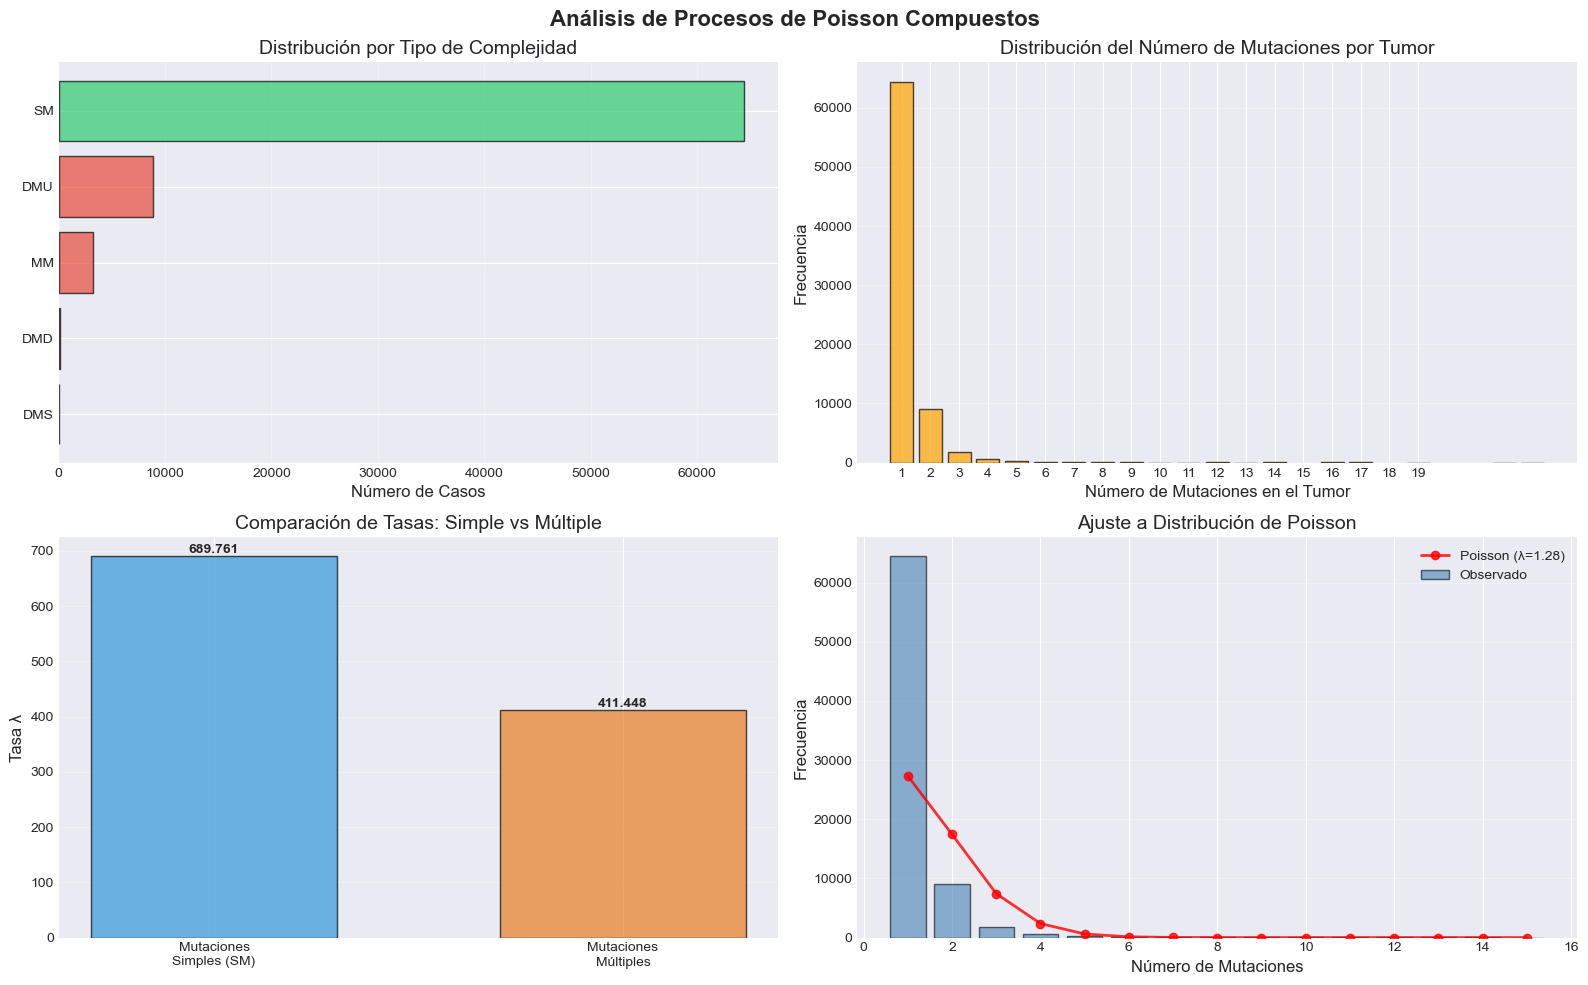


✓ Análisis de procesos compuestos completado


In [39]:
print("="*80)
print("MODELADO DE PROCESOS DE POISSON COMPUESTOS")
print("="*80)

# Análisis de complejidad mutacional
if 'Complejidad' in df_clean.columns:
    complexity_data = df_clean.copy()
    
    # Clasificar por complejidad
    complexity_counts = complexity_data['Complejidad'].value_counts()
    
    print("\n[1] DISTRIBUCIÓN DE COMPLEJIDAD MUTACIONAL")
    print("-"*80)
    print(f"{'Tipo':>20}  {'Frecuencia':>12}  {'Porcentaje':>12}")
    print("-"*80)
    for comp_type, count in complexity_counts.items():
        percentage = (count / len(complexity_data)) * 100
        print(f"{str(comp_type):>20}  {count:>12,}  {percentage:>11.2f}%")
    
    # Análisis de mutaciones múltiples
    multiple_mutations = complexity_data[
        complexity_data['Complejidad'].isin(['DMU', 'DMD', 'DMS', 'MM'])
    ]
    
    print("\n[2] ANÁLISIS DE MUTACIONES MÚLTIPLES")
    print("-"*80)
    print(f"Total de casos con mutaciones múltiples: {len(multiple_mutations):,}")
    print(f"Porcentaje del total: {len(multiple_mutations)/len(complexity_data)*100:.2f}%")
    
    if len(multiple_mutations) > 0:
        # Calcular tasa de eventos múltiples
        lambda_multiple = multiple_mutations['Número_Ocurrencias'].mean()
        lambda_single = complexity_data[complexity_data['Complejidad'] == 'SM']['Número_Ocurrencias'].mean()
        
        print(f"\nλ para mutaciones simples (SM): {lambda_single:.4f}")
        print(f"λ para mutaciones múltiples: {lambda_multiple:.4f}")
        print(f"Ratio λ_múltiple/λ_simple: {lambda_multiple/lambda_single:.2f}")
    
    # Análisis de repetición en tumores
    if 'Repetición_Tumor' in df_clean.columns:
        print("\n[3] DISTRIBUCIÓN DE REPETICIONES EN TUMORES")
        print("-"*80)
        
        tumor_rep_data = df_clean['Repetición_Tumor'].dropna()
        tumor_rep_data = pd.to_numeric(tumor_rep_data, errors='coerce').dropna()
        
        repetition_counts = tumor_rep_data.value_counts().sort_index()
        
        print(f"{'Número_Mutaciones':>18}  {'Tumores':>12}  {'Porcentaje':>12}")
        print("-"*80)
        for rep, count in repetition_counts.head(15).items():
            percentage = (count / len(tumor_rep_data)) * 100
            print(f"{int(rep):>18}  {count:>12,}  {percentage:>11.2f}%")
        
        # Identificar tumores con alta carga mutacional
        high_burden = tumor_rep_data[tumor_rep_data >= 3]
        print(f"\nTumores con ≥3 mutaciones: {len(high_burden):,} ({len(high_burden)/len(tumor_rep_data)*100:.2f}%)")
        
        # Modelar como proceso de Poisson compuesto
        print("\n[4] MODELADO COMO PROCESO COMPUESTO")
        print("-"*80)
        
        # Tasa de llegada de tumores con mutaciones
        lambda_tumors = len(tumor_rep_data)
        
        # Distribución del número de mutaciones por tumor
        mean_mutations_per_tumor = tumor_rep_data.mean()
        var_mutations_per_tumor = tumor_rep_data.var()
        
        print(f"Número total de tumores analizados: {lambda_tumors:,}")
        print(f"Media de mutaciones por tumor: {mean_mutations_per_tumor:.4f}")
        print(f"Varianza de mutaciones por tumor: {var_mutations_per_tumor:.4f}")
        print(f"Índice de dispersión (Var/Media): {var_mutations_per_tumor/mean_mutations_per_tumor:.4f}")
        
        # Parámetro del proceso compuesto
        lambda_compound = lambda_tumors * mean_mutations_per_tumor
        print(f"\nλ del proceso compuesto: {lambda_compound:.2f}")
        print(f"Interpretación: Se esperan {lambda_compound:.0f} mutaciones totales")
    
    # Visualización de procesos compuestos
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Análisis de Procesos de Poisson Compuestos', 
                 fontsize=16, fontweight='bold')
    
    # 1. Distribución de complejidad
    ax1 = axes[0, 0]
    complexity_sorted = complexity_counts.sort_values(ascending=True)
    colors = ['#2ecc71' if x == 'SM' else '#e74c3c' for x in complexity_sorted.index]
    ax1.barh(range(len(complexity_sorted)), complexity_sorted.values, 
             color=colors, alpha=0.7, edgecolor='black')
    ax1.set_yticks(range(len(complexity_sorted)))
    ax1.set_yticklabels(complexity_sorted.index)
    ax1.set_xlabel('Número de Casos')
    ax1.set_title('Distribución por Tipo de Complejidad')
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. Distribución de mutaciones por tumor
    ax2 = axes[0, 1]
    if 'Repetición_Tumor' in df_clean.columns and len(tumor_rep_data) > 0:
        rep_plot = repetition_counts.head(20)
        ax2.bar(rep_plot.index, rep_plot.values, color='orange', 
                alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Número de Mutaciones en el Tumor')
        ax2.set_ylabel('Frecuencia')
        ax2.set_title('Distribución del Número de Mutaciones por Tumor')
        ax2.grid(axis='y', alpha=0.3)
        ax2.set_xticks(range(1, min(21, len(rep_plot) + 1)))
    
    # 3. Comparación λ: Simple vs Múltiple
    ax3 = axes[1, 0]
    if len(multiple_mutations) > 0:
        categories = ['Mutaciones\nSimples (SM)', 'Mutaciones\nMúltiples']
        lambda_values = [lambda_single, lambda_multiple]
        colors_comp = ['#3498db', '#e67e22']
        
        bars = ax3.bar(categories, lambda_values, color=colors_comp, 
                       alpha=0.7, edgecolor='black', width=0.6)
        ax3.set_ylabel('Tasa λ')
        ax3.set_title('Comparación de Tasas: Simple vs Múltiple')
        ax3.grid(axis='y', alpha=0.3)
        
        # Añadir valores sobre las barras
        for i, (bar, val) in enumerate(zip(bars, lambda_values)):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.3f}',
                    ha='center', va='bottom', fontweight='bold')
    
    # 4. Ajuste a distribución teórica
    ax4 = axes[1, 1]
    if 'Repetición_Tumor' in df_clean.columns and len(tumor_rep_data) > 0:
        # Datos observados
        observed_freq = tumor_rep_data.value_counts().sort_index()
        max_val = min(15, observed_freq.index.max())
        x_vals = range(1, max_val + 1)
        
        obs_counts = [observed_freq.get(x, 0) for x in x_vals]
        ax4.bar(x_vals, obs_counts, alpha=0.6, label='Observado', 
                color='steelblue', edgecolor='black')
        
        # Ajuste teórico (Poisson)
        lambda_fit = tumor_rep_data.mean()
        total_tumors = len(tumor_rep_data)
        exp_counts = [total_tumors * poisson.pmf(x, lambda_fit) for x in x_vals]
        
        ax4.plot(x_vals, exp_counts, 'r-o', linewidth=2, markersize=6,
                label=f'Poisson (λ={lambda_fit:.2f})', alpha=0.8)
        
        ax4.set_xlabel('Número de Mutaciones')
        ax4.set_ylabel('Frecuencia')
        ax4.set_title('Ajuste a Distribución de Poisson')
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('poisson_compuesto.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Análisis de procesos compuestos completado")
    
else:
    print("\n⚠ Variable Complejidad no disponible para análisis")

# Cálculo de Intervalos de Tiempo Entre Eventos 
Analizamos los tiempos entre eventos mutacionales, validando que siguen una distribución exponencial (característica de procesos de Poisson).

ANÁLISIS DE INTERVALOS ENTRE EVENTOS

[1] ESTADÍSTICAS DE EVENTOS TEMPORALES
--------------------------------------------------------------------------------
Total de eventos individuales: 49,485,927
Período: 1989 - 2017
Duración: 28 años
Tasa promedio: 1767354.54 eventos/año

[2] ANÁLISIS DE INTERVALOS ENTRE EVENTOS
--------------------------------------------------------------------------------
Intervalos calculados: 28
Intervalo mínimo: 1.0000 años
Intervalo máximo: 1.0000 años
Intervalo medio: 1.0000 años
Mediana: 1.0000 años
Desviación estándar: 0.0000

[3] TEST DE BONDAD DE AJUSTE: DISTRIBUCIÓN EXPONENCIAL
--------------------------------------------------------------------------------
Parámetro rate estimado (λ): 1.0000
Media teórica (1/λ): 1.0000

Test de Kolmogorov-Smirnov:
  Estadístico: 0.6321
  Valor p: 0.0000
  ⚠ Se rechaza H0: Los datos difieren significativamente de exponencial

[4] PROBABILIDADES DE INTERVALOS
------------------------------------------------------------

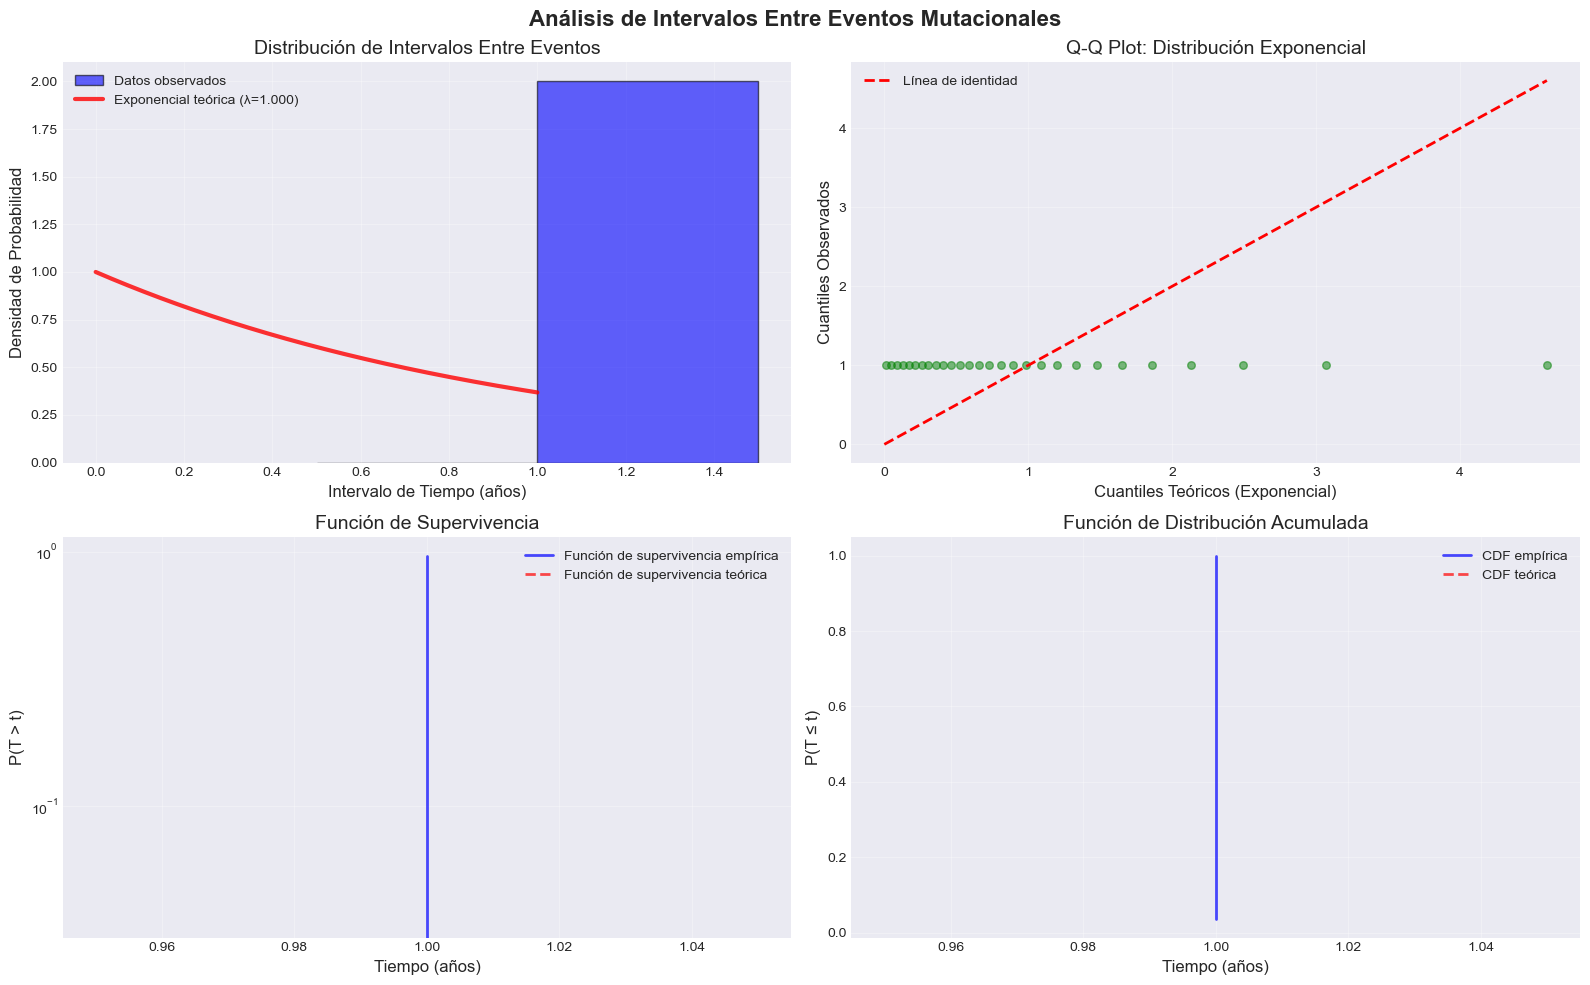


✓ Análisis de intervalos completado


In [40]:
print("="*80)
print("ANÁLISIS DE INTERVALOS ENTRE EVENTOS")
print("="*80)

# Para procesos de Poisson, los tiempos entre eventos siguen distribución exponencial
# Usaremos los datos temporales para este análisis

if 'Año' in df_clean.columns:
    temporal_events = df_clean[df_clean['Año'].notna()].copy()
    temporal_events = temporal_events.sort_values('Año')
    
    # Crear eventos individuales basados en ocurrencias
    event_years = []
    for _, row in temporal_events.iterrows():
        year = row['Año']
        occurrences = int(row['Número_Ocurrencias'])
        event_years.extend([year] * occurrences)
    
    event_years = np.array(sorted(event_years))
    
    print("\n[1] ESTADÍSTICAS DE EVENTOS TEMPORALES")
    print("-"*80)
    print(f"Total de eventos individuales: {len(event_years):,}")
    print(f"Período: {event_years.min():.0f} - {event_years.max():.0f}")
    print(f"Duración: {event_years.max() - event_years.min():.0f} años")
    print(f"Tasa promedio: {len(event_years)/(event_years.max() - event_years.min()):.2f} eventos/año")
    
    # Calcular intervalos entre eventos
    if len(event_years) > 1:
        inter_event_times = np.diff(event_years)
        inter_event_times = inter_event_times[inter_event_times > 0]  # Eliminar ceros
        
        if len(inter_event_times) > 0:
            print("\n[2] ANÁLISIS DE INTERVALOS ENTRE EVENTOS")
            print("-"*80)
            print(f"Intervalos calculados: {len(inter_event_times):,}")
            print(f"Intervalo mínimo: {inter_event_times.min():.4f} años")
            print(f"Intervalo máximo: {inter_event_times.max():.4f} años")
            print(f"Intervalo medio: {inter_event_times.mean():.4f} años")
            print(f"Mediana: {np.median(inter_event_times):.4f} años")
            print(f"Desviación estándar: {inter_event_times.std():.4f}")
            
            # Test de ajuste a distribución exponencial
            print("\n[3] TEST DE BONDAD DE AJUSTE: DISTRIBUCIÓN EXPONENCIAL")
            print("-"*80)
            
            # Estimar parámetro de la exponencial (rate = 1/mean)
            rate_param = 1 / inter_event_times.mean()
            print(f"Parámetro rate estimado (λ): {rate_param:.4f}")
            print(f"Media teórica (1/λ): {1/rate_param:.4f}")
            
            # Test de Kolmogorov-Smirnov
            ks_statistic, ks_pvalue = stats.kstest(inter_event_times, 
                                                    lambda x: expon.cdf(x, scale=1/rate_param))
            print(f"\nTest de Kolmogorov-Smirnov:")
            print(f"  Estadístico: {ks_statistic:.4f}")
            print(f"  Valor p: {ks_pvalue:.4f}")
            
            if ks_pvalue > 0.05:
                print(f"  ✓ No se rechaza H0: Los datos son consistentes con distribución exponencial")
            else:
                print(f"  ⚠ Se rechaza H0: Los datos difieren significativamente de exponencial")
            
            # Probabilidades de intervalos específicos
            print("\n[4] PROBABILIDADES DE INTERVALOS")
            print("-"*80)
            intervals = [0.5, 1.0, 2.0, 5.0, 10.0]
            print(f"{'Intervalo (años)':>18}  {'P(T ≤ t)':>12}  {'P(T > t)':>12}")
            print("-"*80)
            for t in intervals:
                prob_less = expon.cdf(t, scale=1/rate_param)
                prob_greater = 1 - prob_less
                print(f"{t:>18.1f}  {prob_less:>12.4f}  {prob_greater:>12.4f}")
            
            # Visualización
            fig, axes = plt.subplots(2, 2, figsize=(16, 10))
            fig.suptitle('Análisis de Intervalos Entre Eventos Mutacionales', 
                         fontsize=16, fontweight='bold')
            
            # 1. Histograma de intervalos vs exponencial teórica
            ax1 = axes[0, 0]
            n_bins = min(50, len(inter_event_times) // 10)
            counts, bins, patches = ax1.hist(inter_event_times, bins=n_bins, 
                                             density=True, alpha=0.6, 
                                             color='blue', edgecolor='black',
                                             label='Datos observados')
            
            # Curva exponencial teórica
            x_theoretical = np.linspace(0, inter_event_times.max(), 1000)
            y_theoretical = expon.pdf(x_theoretical, scale=1/rate_param)
            ax1.plot(x_theoretical, y_theoretical, 'r-', linewidth=3,
                    label=f'Exponencial teórica (λ={rate_param:.3f})', alpha=0.8)
            
            ax1.set_xlabel('Intervalo de Tiempo (años)')
            ax1.set_ylabel('Densidad de Probabilidad')
            ax1.set_title('Distribución de Intervalos Entre Eventos')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # 2. Q-Q plot
            ax2 = axes[0, 1]
            theoretical_quantiles = expon.ppf(np.linspace(0.01, 0.99, len(inter_event_times)), 
                                              scale=1/rate_param)
            observed_quantiles = np.sort(inter_event_times)
            
            ax2.scatter(theoretical_quantiles, observed_quantiles, 
                       alpha=0.5, s=30, color='green')
            
            # Línea de identidad
            max_val = max(theoretical_quantiles.max(), observed_quantiles.max())
            ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, 
                    label='Línea de identidad')
            
            ax2.set_xlabel('Cuantiles Teóricos (Exponencial)')
            ax2.set_ylabel('Cuantiles Observados')
            ax2.set_title('Q-Q Plot: Distribución Exponencial')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # 3. Función de supervivencia
            ax3 = axes[1, 0]
            sorted_times = np.sort(inter_event_times)
            survival_empirical = 1 - np.arange(1, len(sorted_times) + 1) / len(sorted_times)
            survival_theoretical = expon.sf(sorted_times, scale=1/rate_param)
            
            ax3.plot(sorted_times, survival_empirical, 'b-', linewidth=2,
                    label='Función de supervivencia empírica', alpha=0.7)
            ax3.plot(sorted_times, survival_theoretical, 'r--', linewidth=2,
                    label='Función de supervivencia teórica', alpha=0.7)
            
            ax3.set_xlabel('Tiempo (años)')
            ax3.set_ylabel('P(T > t)')
            ax3.set_title('Función de Supervivencia')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            ax3.set_yscale('log')
            
            # 4. Función de distribución acumulada
            ax4 = axes[1, 1]
            empirical_cdf = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
            theoretical_cdf = expon.cdf(sorted_times, scale=1/rate_param)
            
            ax4.plot(sorted_times, empirical_cdf, 'b-', linewidth=2,
                    label='CDF empírica', alpha=0.7)
            ax4.plot(sorted_times, theoretical_cdf, 'r--', linewidth=2,
                    label='CDF teórica', alpha=0.7)
            
            ax4.set_xlabel('Tiempo (años)')
            ax4.set_ylabel('P(T ≤ t)')
            ax4.set_title('Función de Distribución Acumulada')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('intervalos_entre_eventos.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("\n✓ Análisis de intervalos completado")
        
        else:
            print("\n⚠ No hay suficientes intervalos únicos para análisis")
    else:
        print("\n⚠ Insuficientes eventos para calcular intervalos")
else:
    print("\n⚠ Variable temporal no disponible")

# Reporte Final y Resumen Ejecutivo 
Generamos un reporte comprehensivo con todos los hallazgos principales y exporta los resultados para documentación.

In [41]:
print("="*80)
print("GENERACIÓN DE REPORTE FINAL")
print("="*80)

# Crear diccionario con resultados principales
final_results = {}

# 1. Estadísticas generales
final_results['datos_generales'] = {
    'total_mutaciones': len(df_clean),
    'total_eventos': df_clean['Número_Ocurrencias'].sum(),
    'periodo_analisis': f"{int(df_clean['Año'].min())} - {int(df_clean['Año'].max())}" if 'Año' in df_clean.columns else 'N/A',
    'lambda_global': lambda_global,
    'ic_95_inferior': ci_lower,
    'ic_95_superior': ci_upper
}

# 2. Resultados de validación
final_results['validacion_poisson'] = {
    'test_chi2_statistic': global_test['chi2_statistic'],
    'test_p_value': global_test['p_value'],
    'compatible_con_poisson': not global_test['reject_H0'],
    'indice_dispersion': dispersion_index
}

# 3. Hotspots identificados
if 'Codón' in df_clean.columns:
    final_results['hotspots'] = {
        'num_hotspots_p95': len(hotspots),
        'threshold_p95': threshold_95,
        'top_5_codones': top_hotspots.head(5)['Codón'].tolist()
    }

# 4. Análisis temporal
if 'Año' in df_clean.columns and len(year_lambda) > 0:
    final_results['tendencia_temporal'] = {
        'pendiente': slope,
        'r_cuadrado': r_value**2,
        'p_value': p_value,
        'tendencia_significativa': p_value < 0.05,
        'direccion': 'Creciente' if slope > 0 else 'Decreciente'
    }

# Generar reporte en texto
print("\n" + "="*80)
print("RESUMEN EJECUTIVO: ANÁLISIS DE PROCESOS DE POISSON")
print("MUTACIONES EN EL GEN TP53")
print("="*80)

print("\n" + "-"*80)
print("1. DATOS GENERALES")
print("-"*80)
print(f"  • Total de variantes analizadas: {final_results['datos_generales']['total_mutaciones']:,}")
print(f"  • Total de eventos mutacionales: {final_results['datos_generales']['total_eventos']:,}")
print(f"  • Período de análisis: {final_results['datos_generales']['periodo_analisis']}")

print("\n" + "-"*80)
print("2. PARÁMETROS DEL PROCESO DE POISSON")
print("-"*80)
print(f"  • Tasa global estimada (λ): {final_results['datos_generales']['lambda_global']:.4f}")
print(f"  • Intervalo de confianza 95%: [{final_results['datos_generales']['ic_95_inferior']:.4f}, "
      f"{final_results['datos_generales']['ic_95_superior']:.4f}]")
print(f"  • Interpretación: En promedio, cada variante ocurre {final_results['datos_generales']['lambda_global']:.2f} veces")

print("\n" + "-"*80)
print("3. VALIDACIÓN DEL MODELO")
print("-"*80)
print(f"  • Test de bondad de ajuste χ²: {final_results['validacion_poisson']['test_chi2_statistic']:.4f}")
print(f"  • Valor p: {final_results['validacion_poisson']['test_p_value']:.4f}")
print(f"  • Índice de dispersión (Var/Media): {final_results['validacion_poisson']['indice_dispersion']:.4f}")

if final_results['validacion_poisson']['compatible_con_poisson']:
    print(f"  • ✓ CONCLUSIÓN: Los datos son compatibles con un Proceso de Poisson")
else:
    print(f"  • ⚠ CONCLUSIÓN: Los datos muestran desviaciones del modelo de Poisson")

if dispersion_index > 1.5:
    print(f"  • Nota: Sobredispersión detectada. Considerar modelos alternativos:")
    print(f"    - Proceso de Poisson Compuesto")
    print(f"    - Distribución Binomial Negativa")

if 'hotspots' in final_results:
    print("\n" + "-"*80)
    print("4. HOTSPOTS MUTACIONALES")
    print("-"*80)
    print(f"  • Hotspots identificados (percentil 95): {final_results['hotspots']['num_hotspots_p95']}")
    print(f"  • Threshold de clasificación: ≥ {final_results['hotspots']['threshold_p95']:.0f} mutaciones")
    print(f"  • Top 5 codones más mutados: {', '.join(map(str, [int(c) for c in final_results['hotspots']['top_5_codones']]))}")
    
    if 'Es_Hotspot' in df_clean.columns:
        print(f"  • Ratio λ_CpG/λ_No-CpG: {ratio:.2f}x")
        print(f"  • Los sitios CpG tienen una tasa {ratio:.1f} veces mayor de mutación")

if 'tendencia_temporal' in final_results:
    print("\n" + "-"*80)
    print("5. ANÁLISIS TEMPORAL (PROCESO NO HOMOGÉNEO)")
    print("-"*80)
    print(f"  • Modelo: λ(t) = {intercept:.4f} + {slope:.6f}·t")
    print(f"  • R² del modelo: {final_results['tendencia_temporal']['r_cuadrado']:.4f}")
    print(f"  • Valor p: {final_results['tendencia_temporal']['p_value']:.4f}")
    
    if final_results['tendencia_temporal']['tendencia_significativa']:
        print(f"  • ✓ Tendencia {final_results['tendencia_temporal']['direccion'].lower()} SIGNIFICATIVA detectada")
        if slope > 0:
            print(f"  • La tasa de mutación aumenta {slope:.6f} unidades por año")
        else:
            print(f"  • La tasa de mutación disminuye {abs(slope):.6f} unidades por año")
    else:
        print(f"  • El proceso es aproximadamente homogéneo en el tiempo")

print("\n" + "-"*80)
print("6. APLICACIONES PRÁCTICAS")
print("-"*80)
print("  • Predicción del número esperado de mutaciones en nuevas muestras")
print("  • Identificación de regiones genómicas de alto riesgo (hotspots)")
print("  • Modelado de tiempos entre eventos mutacionales")
print("  • Evaluación de heterogeneidad espacial y temporal")
print("  • Soporte para decisiones clínicas y terapéuticas")

print("\n" + "-"*80)
print("7. RECOMENDACIONES")
print("-"*80)

if dispersion_index > 1.5:
    print("  • Implementar modelo de Poisson Compuesto para capturar sobredispersión")

if 'tendencia_temporal' in final_results and final_results['tendencia_temporal']['tendencia_significativa']:
    print("  • Considerar efectos temporales en predicciones futuras")

if 'hotspots' in final_results:
    print("  • Enfocar esfuerzos de secuenciación en hotspots identificados")
    print("  • Priorizar codones en percentil 95 para análisis funcionales")

print("\n" + "="*80)
print("REPORTE GENERADO EXITOSAMENTE")
print("="*80)

# Exportar resultados a archivo Excel
print("\n[EXPORTACIÓN DE RESULTADOS]")

# Crear DataFrames para exportar
export_data = {
    'Resumen_General': pd.DataFrame([final_results['datos_generales']]),
    'Validacion_Modelo': pd.DataFrame([final_results['validacion_poisson']]),
    'Lambda_por_Tipo': pd.DataFrame(lambda_by_type).T if lambda_by_type else pd.DataFrame(),
    'Dataset_Procesado': df_clean
}

# Exportar a Excel
output_file = 'Resultados_Poisson_TP53.xlsx'
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for sheet_name, data in export_data.items():
        if not data.empty:
            data.to_excel(writer, sheet_name=sheet_name, index=True)

print(f"✓ Resultados exportados a: {output_file}")

# Guardar reporte en texto
with open('Reporte_Analisis_Poisson_TP53.txt', 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("REPORTE TÉCNICO: ANÁLISIS DE PROCESOS DE POISSON\n")
    f.write("MUTACIONES EN EL GEN TP53\n")
    f.write("="*80 + "\n\n")
    f.write(f"Fecha de generación: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    for key, value in final_results.items():
        f.write(f"\n{key.upper().replace('_', ' ')}:\n")
        f.write("-"*80 + "\n")
        for subkey, subvalue in value.items():
            f.write(f"  {subkey}: {subvalue}\n")

print(f"✓ Reporte técnico guardado en: Reporte_Analisis_Poisson_TP53.txt")

print("\n" + "="*80)
print("ANÁLISIS COMPLETADO EXITOSAMENTE")
print("="*80)
print("\nArchivos generados:")
print("  1. EDA_mutaciones_TP53.png")
print("  2. validacion_poisson.png")
print("  3. poisson_no_homogeneo.png")
print("  4. hotspots_mutacionales.png")
print("  5. poisson_compuesto.png")
print("  6. intervalos_entre_eventos.png")
print("  7. Resultados_Poisson_TP53.xlsx")
print("  8. Reporte_Analisis_Poisson_TP53.txt")
print("\n✓ Todos los análisis han sido ejecutados correctamente")

GENERACIÓN DE REPORTE FINAL

RESUMEN EJECUTIVO: ANÁLISIS DE PROCESOS DE POISSON
MUTACIONES EN EL GEN TP53

--------------------------------------------------------------------------------
1. DATOS GENERALES
--------------------------------------------------------------------------------
  • Total de variantes analizadas: 76,696
  • Total de eventos mutacionales: 49,485,927
  • Período de análisis: 1989 - 2017

--------------------------------------------------------------------------------
2. PARÁMETROS DEL PROCESO DE POISSON
--------------------------------------------------------------------------------
  • Tasa global estimada (λ): 645.2217
  • Intervalo de confianza 95%: [645.0420, 645.4015]
  • Interpretación: En promedio, cada variante ocurre 645.22 veces

--------------------------------------------------------------------------------
3. VALIDACIÓN DEL MODELO
--------------------------------------------------------------------------------
  • Test de bondad de ajuste χ²: 0.0000
